<p style="text-align: right;">This notebook is best viewed in an appropriate environment, such as Jupyter Lab or <a href="https://nbviewer.jupyter.org/github/NLP-Project-CRT/NLP-Project/blob/main/github_lang_report.ipynb">nbviewer</a>.</p>


<h1>GitHub Repositories and Programming Language</h1>

&nbsp;**Using NLP to Predict Constructed Language**<br>
_August 2, 2021_

<br>
<center><img src='./assets/header.png'><br>
[<a href="#Data-Acquisition">acquire</a>]
[<a href="#Data-Preparation">prepare</a>]
[<a href="#Exploration">explore</a>]
[<a href="#Modeling">models</a>]
[<a href="#Final-Test">test</a>]
[<a href="#Conclusion">summary</a>]
</center>

<br>

## Project Summary

### Goals

Every individual GitHub repository houses a unique contribution to the respective field of their creators. They are created with one or more of myriad constructed languages, from Python to JavaScript. Using natural language processing (NLP) methodologies, the ambition held within this project is to create a classifier capable of using the natural language of a repository's `README` file to predict the dominant programming language utilized within.

### Initial Thoughts

Initial expectations in project planning were that creating a classifier that was capable of outperforming a baseline assumption of the majority class would be quite an undertaking. Using repositories for only a specific topic, it was hoped that this would control for subject matter language from potentially obfuscating findings and classifier predictions; however, due to the similar nature of **Ju**lia, **Pyt**hon, and **R** to Jupyter, it was expected these items would create additional complications.

### Findings

As initially expected, the complications between Python, R, and Jupyter resulted in heavy inaccuracies in predicting these two classes in out-of-sample data; however, despite this complication it was possible to construct a `DecisionTreeClassifier` that was capable of outperforming the baseline predictions of the majority class. This resulted in a final test accuracy $\approx58\%$ compared to $\approx44\%$ baseline prediction. With the time afford, a solution to this was not able to be found, but several ideas for improving are recommended below.

### Next Phase

The biggest hurdle in accurate predicting target class was due to similarity and relationship of certain "languages" to each other. Moving from here, it is recommended to obtain secondary languages from repositories where they exist in order to determine underlying language against the more weighted environment. Secondly, due to end result model making use of the term `python` from certain README contents, it is advisable to remove all self-referential language from all README contents to prevent fitting to observations that make use of it, but having out-of-sample data which does not contain features being marked as high-importance.

<br>

**Initialize Notebook**

In [1]:
# import standard libraries
import pandas as pd
import numpy as np

# import visualization
import matplotlib.pyplot as plt
from wordcloud.wordcloud import WordCloud

# import text assessment tools
from functools import reduce
import nltk

# import create functions
from wrangle import open_json_data
import prepare as p
import wrangle as w
from wrangle import wrangle_github_repos

# cosmetic settings
import warnings
warnings.filterwarnings("ignore")
from matplotlib.style import use
use('whatever.mplstyle')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christophermayorga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christophermayorga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Acquisition

Running the `acquire.py` script from the command line created the `data2.json` file that containing the repository name, programming language specified by GitHub, and the raw contents of the `README.md` file. This data is read in using `open_json_data` from the `wrangle.py` module. 

In [2]:
# read in json data as DataFrame
df = open_json_data()

In [3]:
# view dimensions and structure of DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 1 to 681
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             612 non-null    object
 1   language         612 non-null    object
 2   readme_contents  612 non-null    object
dtypes: object(3)
memory usage: 19.1+ KB


In [4]:
# view preview of first rows
df.head(3)

repo    language  \
1  covid19india/covid19india-react  JavaScript   
3   tokyo-metropolitan-gov/covid19         Vue   
4               owid/covid-19-data      Python   

                                     readme_contents  
1  <p align="center">\n<img src="https://reposito...  
3  # Êù±‰∫¨ÈÉΩ Êñ∞Âûã„Ç≥„É≠„Éä„Ç¶„Ç§„É´„ÇπÊÑüÊüìÁóáÂØæÁ≠ñ„Çµ„Ç§„Éà\n\n[![production deplo...  
4  # COVID-19 Dataset by _Our World in Data_ \n[!...

### Data Preparation

With the data having been read into a DataFrame from the JSON data file, it is time to prepare it in a manner for for manual, visual exploration. The cells in the following section contain brief overviews of each step in preparation of the data.

In [5]:
# inspect readme_contents for second row
df.readme_contents.iloc[1]

'# Êù±‰∫¨ÈÉΩ Êñ∞Âûã„Ç≥„É≠„Éä„Ç¶„Ç§„É´„ÇπÊÑüÊüìÁóáÂØæÁ≠ñ„Çµ„Ç§„Éà\n\n[![production deploy](https://github.com/tokyo-metropolitan-gov/covid19/workflows/production%20deploy/badge.svg?branch=master)](https://github.com/tokyo-metropolitan-gov/covid19/actions?query=workflow%3A%22production+deploy%22)\n[![OGP Builder](https://github.com/tokyo-metropolitan-gov/covid19/workflows/OGP%20Builder/badge.svg?branch=master)](https://github.com/tokyo-metropolitan-gov/covid19/actions?query=workflow%3A%22OGP+Builder%22)\n[![Auto-i18n Generator](https://github.com/tokyo-metropolitan-gov/covid19/workflows/Auto-i18n%20Generator/badge.svg?branch=development)](https://github.com/tokyo-metropolitan-gov/covid19/actions?query=workflow%3A%22Auto-i18n+Generator%22)\n\n[![Êù±‰∫¨ÈÉΩ Êñ∞Âûã„Ç≥„É≠„Éä„Ç¶„Ç§„É´„ÇπÊÑüÊüìÁóáÂØæÁ≠ñ„Çµ„Ç§„Éà](https://user-images.githubusercontent.com/1301149/75629392-1d19d900-5c25-11ea-843d-2d4376e3a560.png)](https://stopcovid19.metro.tokyo.lg.jp/)\n\n### Êó•Êú¨Ë™û | [English](./docs/en/REA

**Notes**

- Filter non-English contents from DataFrame
- Remove code for HTML, markdown, etc.
- Perform content cleaning functions

In [6]:
# use function from wrangle to filter non-EN
df = w.get_english_only(df)
# remove code in readme_contents
df = w.remove_code_snippets(df)

In [7]:
# create column for cleaned, tokenized string with stopwords removed
df = w.extensive_clean(df)

In [8]:
# create columns for count of characters in original and cleaned contents
df = w.create_char_counts(df)
# create column for the percentage difference in above columns
df = w.create_pct_changed(df)

In [9]:
# view languages present
df.language.value_counts(dropna=False)

Python              142
JavaScript          116
Jupyter Notebook     69
HTML                 37
TypeScript           29
R                    25
Dart                 19
Java                 16
Kotlin               12
PHP                   9
Vue                   9
C++                   8
CSS                   7
C#                    6
Swift                 6
Shell                 6
Go                    6
Ruby                  4
TeX                   3
Clojure               2
Julia                 2
Dockerfile            2
SCSS                  2
Roff                  1
C                     1
Stan                  1
Reason                1
Common Lisp           1
Pascal                1
Elixir                1
MATLAB                1
Mathematica           1
Nextflow              1
F#                    1
Objective-C           1
G-code                1
Nix                   1
GAML                  1
Name: language, dtype: int64

**Notes**

- Ensure each class for target has adequate observations
    - Looking for 10+ observations after all cleaning, filtering is performed

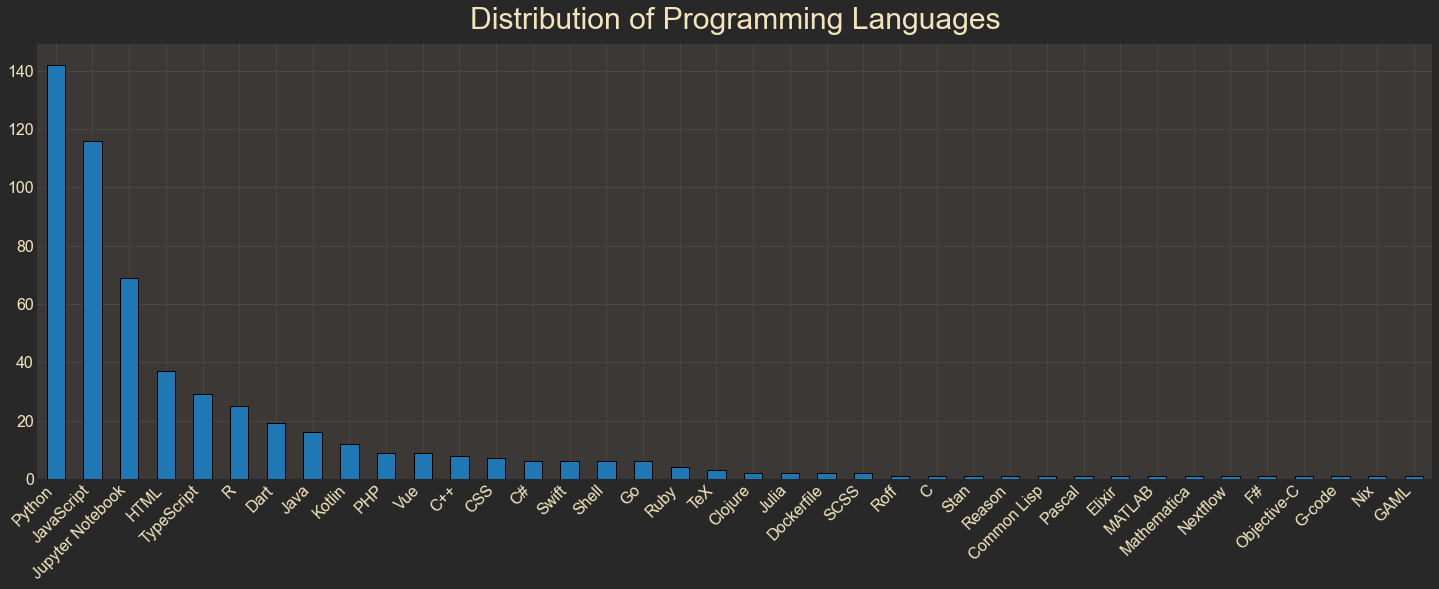

In [10]:
# plot distribution of target
df.language.value_counts().plot.bar(ec='k')
plt.title('Distribution of Programming Languages', fontsize=30, pad=15)
plt.xticks(rotation=45, ha='right')
plt.show()

In [11]:
# filter DataFrame to only languages with sufficent observations
df = w.filter_language(df)

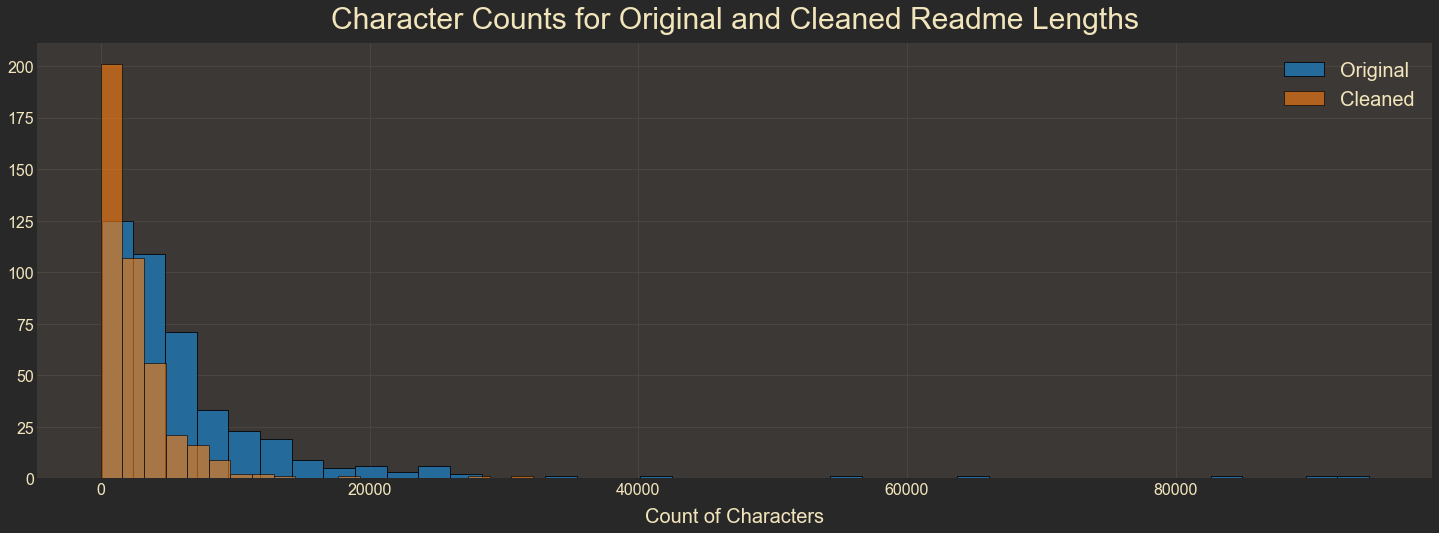

In [12]:
# plot distribution of clean and original character lengths
fig, ax = plt.subplots()
df.original_char_length.hist(ax=ax, bins=40, ec='k', label='Original', alpha=0.8)
df.cleaned_char_length.hist(ax=ax, bins=20, ec='k', label='Cleaned', alpha=0.6)
plt.title('Character Counts for Original and Cleaned Readme Lengths',
          fontsize=30, pad=15)
plt.xlabel('Count of Characters', fontsize=20, labelpad=10)
plt.legend(fontsize=20)
plt.show()

In [13]:
# rename columns, remove char length outliers, create lemmatized
df = w.polish_github_repos(df)

In [14]:
# view DataFrame preview to see changes
df.head(3)

repository  \
0  ieee8023/covid-chestxray-dataset   
1                     geohot/corona   
2             ahmadawais/corona-cli   

                                     original_readme  \
0  \n#### üõë Note: please do not claim diagnostic ...   
1  # Reverse engineering the coronavirus (SARS-Co...   
2  <h4 align="center">\n    <a href="https://gith...   

                                      cleaned_readme  \
0  note please claim diagnostic performance model...   
1  reverse engineering coronavirus sars cov 2 sta...   
2  track coronavirus disease covid 19 novel coron...   

                                   lemmatized_readme  original_char_length  \
0  note please claim diagnostic performance model...                 10610   
1  reverse engineering coronavirus sars cov 2 sta...                 13101   
2  track coronavirus disease covid 19 novel coron...                 15371   

   cleaned_char_length  pct_char_removed natural_language programming_language  
0                 4170                39               en     Jupyter Notebook  
1                 3883                29               en               Python  
2                 4850                31               en           JavaScript

#### Takeaways

There are definitely observations present with `readme_content` that is not English. First thing to do is ensure that all non-EN data is filtered out of the DataFrame. This will be done using the `langdetect` library and Google API. There is code, such as Markdown, HTML, and naked hyperlinks, present in the contents. These will need to be removed as well to reduce errors in natural language cleaning and $n$gram creation.

Programming language being the target variable, the DataFrame will need to contain adequate observations for each language. Removing languages that do not have at least ten observations present will need to be removed. Observations that are too short or too long will be removed to prevent outliers from obfuscating underlying patterns with superfluous content.

Lastly, the data will need to be split to prevent exploration on out-of-sample data and prepare for modeling and evaluation phases.

### Exploration

In [15]:
# wrangle data into prepare DataFrames
X_train, y_train, \
X_validate, y_validate, \
X_test, y_test = wrangle_github_repos()

In [16]:
X_train.head(3)

repository  \
143    InstituteforDiseaseModeling/synthpops   
70                   covid19-model/simulator   
180  code4romania/covid-19-ce-trebuie-sa-fac   

                                       original_readme  \
143  # SynthPops\n\nSynthPops is a module designed ...   
70   \n\n\n\n# Quantifying the Effects of Contact T...   
180  # Ce trebuie sƒÉ fac - Web platform with guides...   

                                        cleaned_readme  \
143  synthpops synthpops module designed generate s...   
70   quantifying effects contact tracing testing co...   
180  ce trebuie sa fac web platform guides question...   

                                     lemmatized_readme  original_char_length  \
143  synthpops synthpops module designed generate s...                  5324   
70   quantifying effect contact tracing testing con...                  7529   
180  ce trebuie sa fac web platform guide questionn...                  4615   

     cleaned_char_length  pct_char_removed natural_language  
143                 3498                65               en  
70                  4490                59               en  
180                 1957                42               en

### Single Word Frequencies

In [17]:
# create series of top 20 words across all languages
all_words = ' '.join(X_train.lemmatized_readme) .replace('\'', '')
all_lang_words = pd.Series(all_words.split())

In [18]:
# create series of words for each proggramming language
py_words = pd.Series(' '.join(X_train[y_train.programming_language == 'Python']\
                           .lemmatized_readme).replace('\'', '').split())
js_words = pd.Series(' '.join(X_train[y_train.programming_language == 'JavaScript']\
                           .lemmatized_readme).replace('\'', '').split())
jup_words = pd.Series(' '.join(X_train[y_train.programming_language == 'Jupyter Notebook']\
                           .lemmatized_readme).replace('\'', '').split())
html_words = pd.Series(' '.join(X_train[y_train.programming_language == 'HTML']\
                           .lemmatized_readme).replace('\'', '').split())
r_words = pd.Series(' '.join(X_train[y_train.programming_language == 'R']\
                           .lemmatized_readme).replace('\'', '').split())
ts_words = pd.Series(' '.join(X_train[y_train.programming_language == 'TypeScript']\
                           .lemmatized_readme).replace('\'', '').split())

In [19]:
# find words common to all languages
common_words = [py_words, js_words, jup_words, html_words, r_words, ts_words]
common_words = list(reduce(lambda i, j: i & j, (set(n) for n in common_words)))

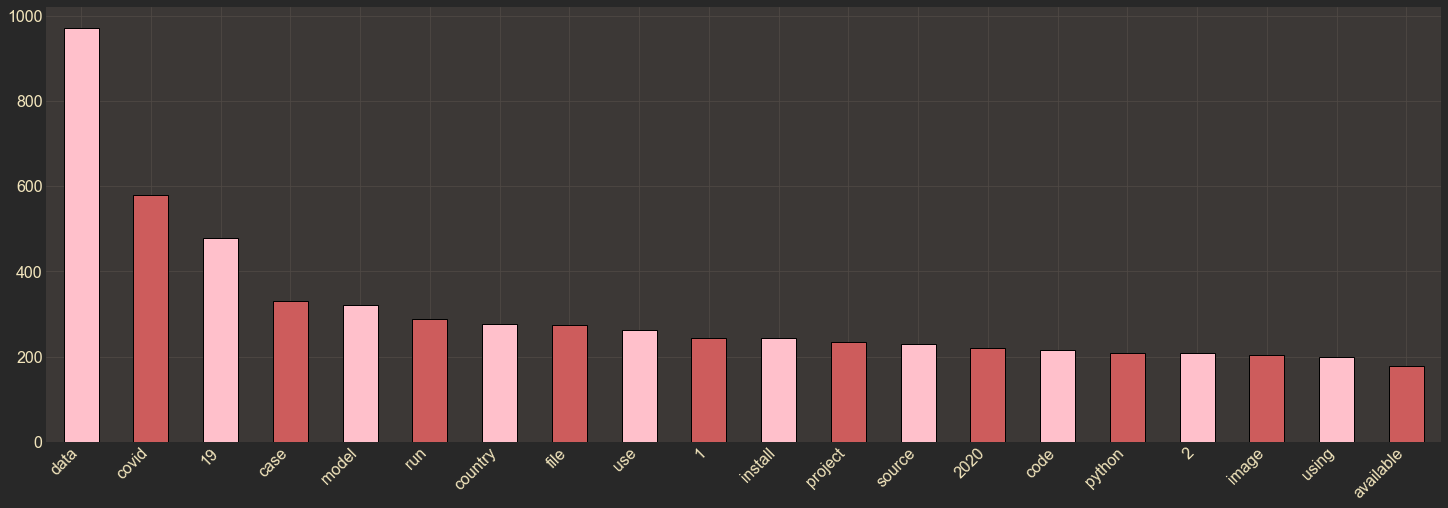

In [20]:
# visualize top 20 common words across all languages
all_words_freq = all_lang_words.value_counts().sort_values(ascending=False)
top_20_words = all_words_freq.head(20)
top_20_words.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

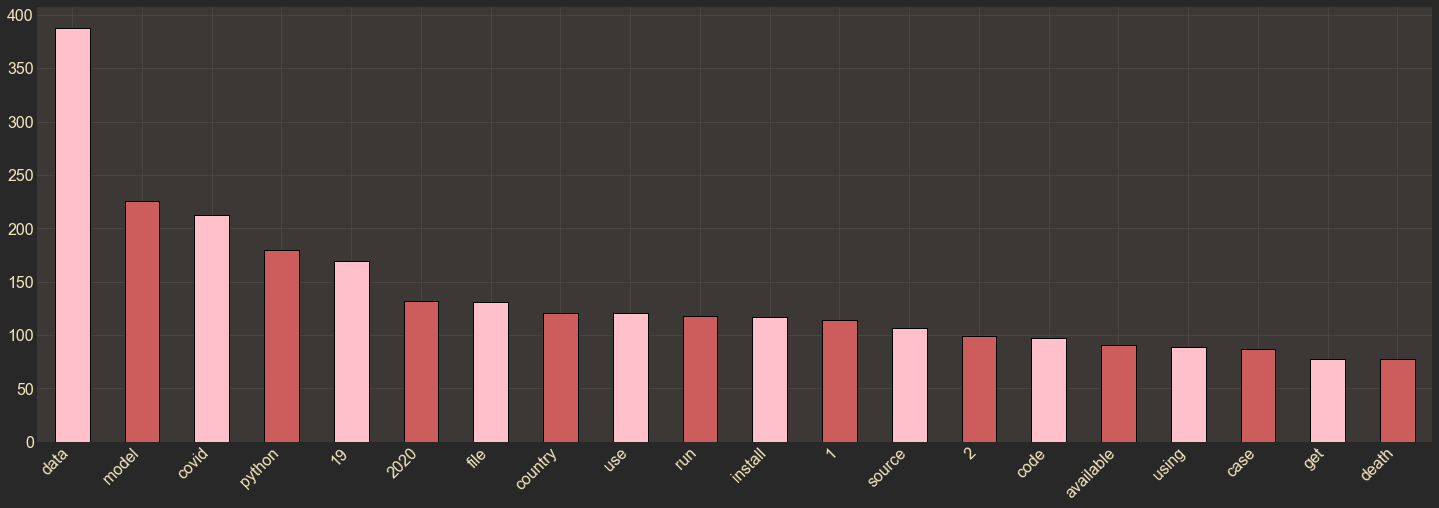

In [21]:
# visualize top 20 common words in Python
py_words_freq = py_words.value_counts().sort_values(ascending=False)
py_top_20 = py_words_freq.head(20)
py_top_20.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

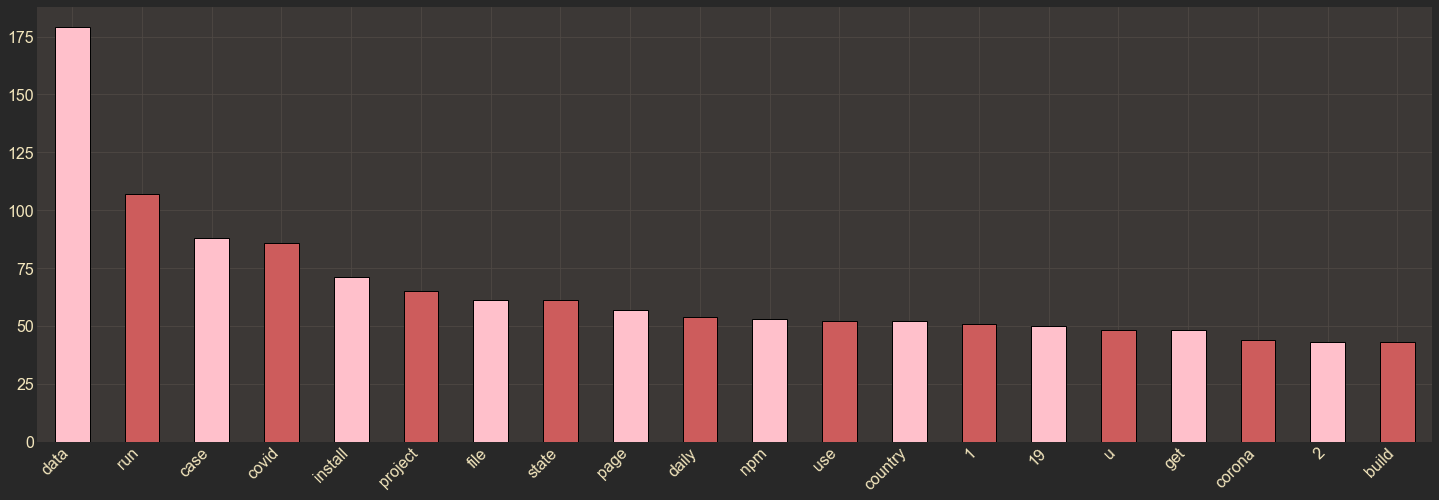

In [22]:
# visualize top 20 common words in JavaScript
js_words_freq = js_words.value_counts().sort_values(ascending=False)
js_top_20 = js_words_freq.head(20)
js_top_20.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

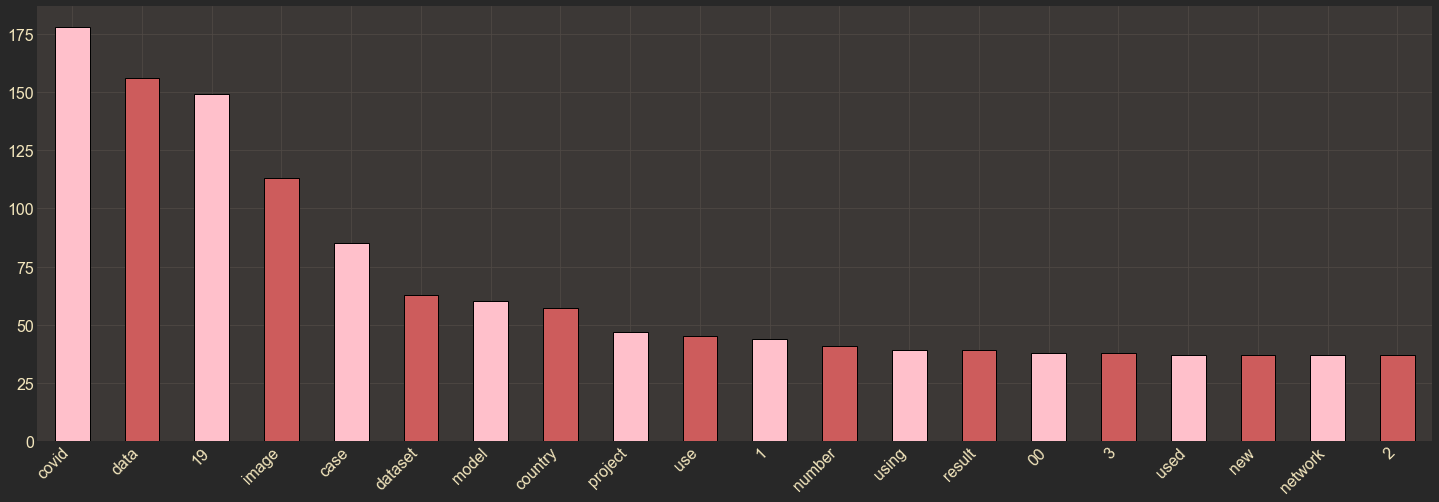

In [23]:
# visualize top 20 common words in Jupyter
jup_words_freq = jup_words.value_counts().sort_values(ascending=False)
jup_top_20 = jup_words_freq.head(20)
jup_top_20.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

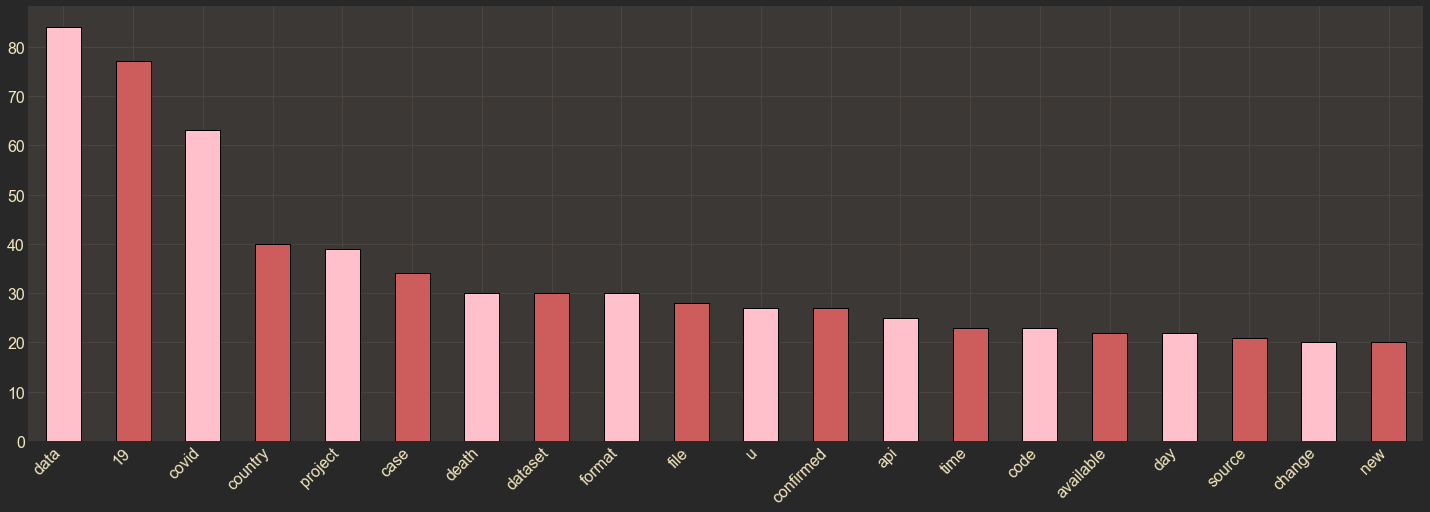

In [24]:
# visualize top 20 common words in HTML
html_words_freq = html_words.value_counts().sort_values(ascending=False)
html_top_20 = html_words_freq.head(20)
html_top_20.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

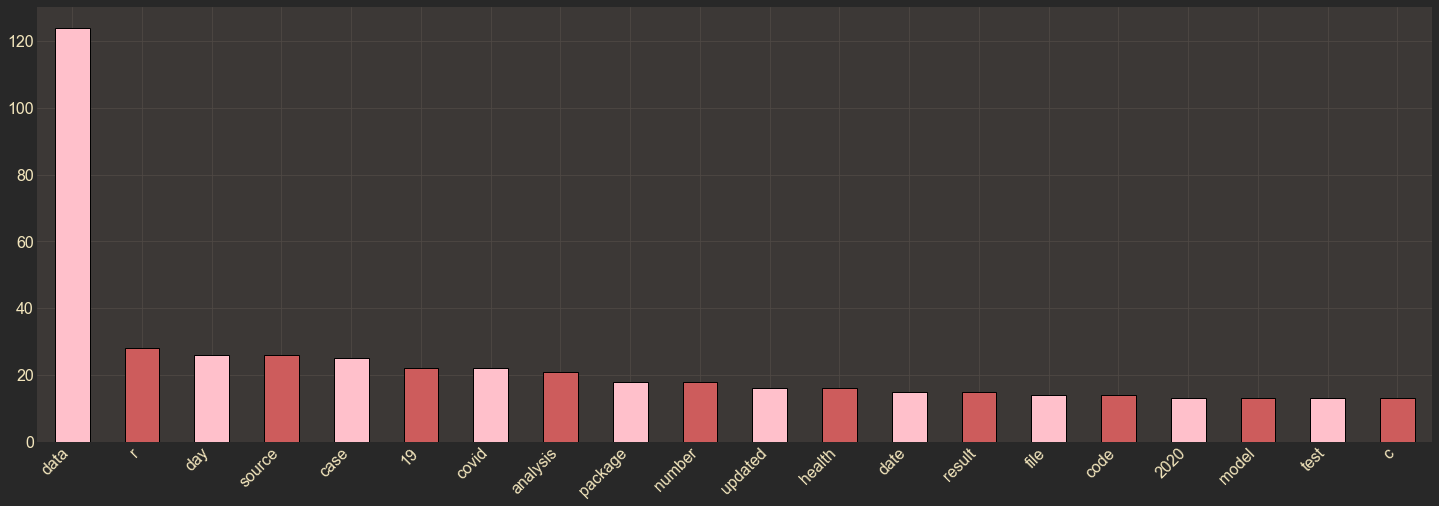

In [25]:
# visualize top 20 common words in R
r_words_freq = r_words.value_counts().sort_values(ascending=False)
r_top_20 = r_words_freq.head(20)
r_top_20.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

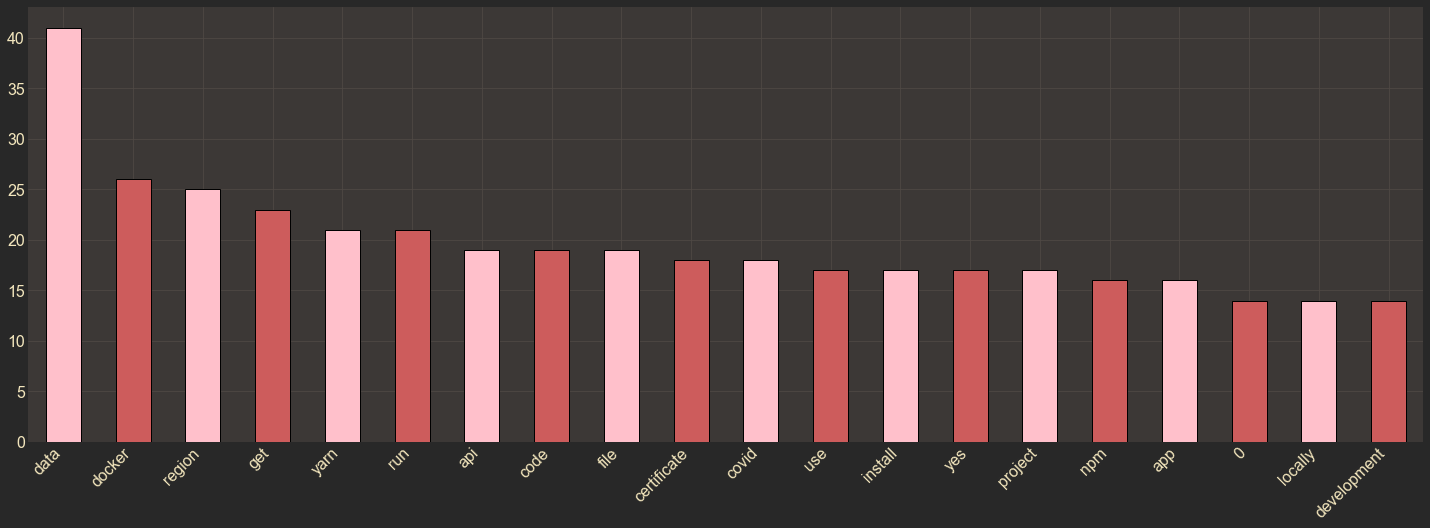

In [26]:
# visualize top 20 common words in TypeScript
ts_words_freq = ts_words.value_counts().sort_values(ascending=False)
ts_top_20 = ts_words_freq.head(20)
ts_top_20.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

#### Common Elements

In [27]:
# create DataFrame for word freq for all and per language
word_freq = pd.concat([all_words_freq,
                       py_words_freq,
                       js_words_freq,
                       jup_words_freq,
                       html_words_freq,
                       r_words_freq,
                       ts_words_freq],
                       axis=1,
                       sort=True)\
                .set_axis(['all_words', 'py_words',
                           'js_words', 'jup_words',
                           'html_words', 'r_words',
                           'ts_words'], axis=1,
                           inplace=False)\
                .fillna(0)\
                .apply(lambda s: s.astype(int))
# subset word freq into top 20 all word frequencies
top_20_word_freq = word_freq.sort_values('all_words', ascending=False).head(20)

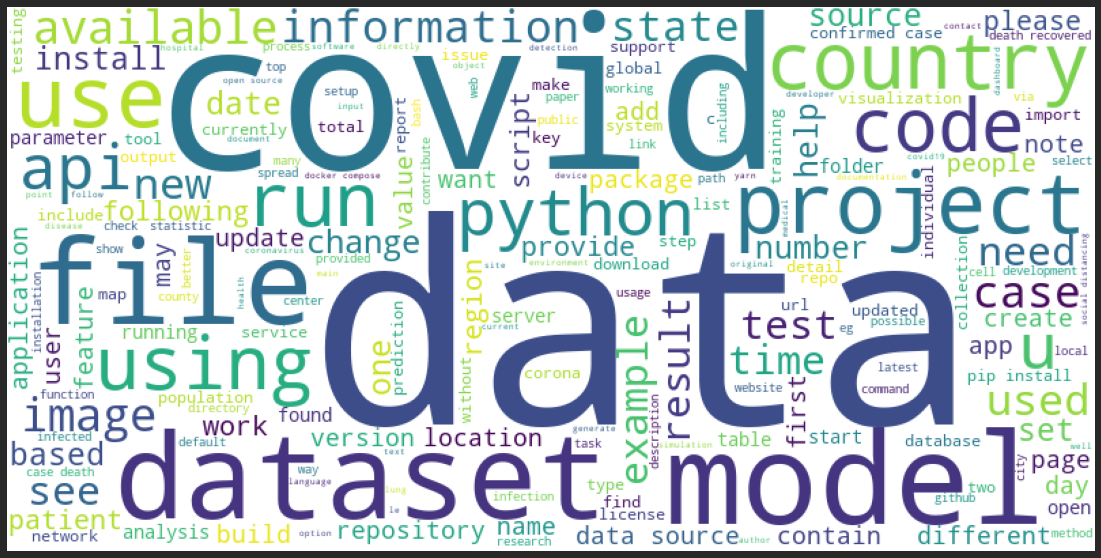

In [28]:
# visualize wordcloud of top 20 overall words
img = WordCloud(background_color='white', width=800, height=400).generate(all_words)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

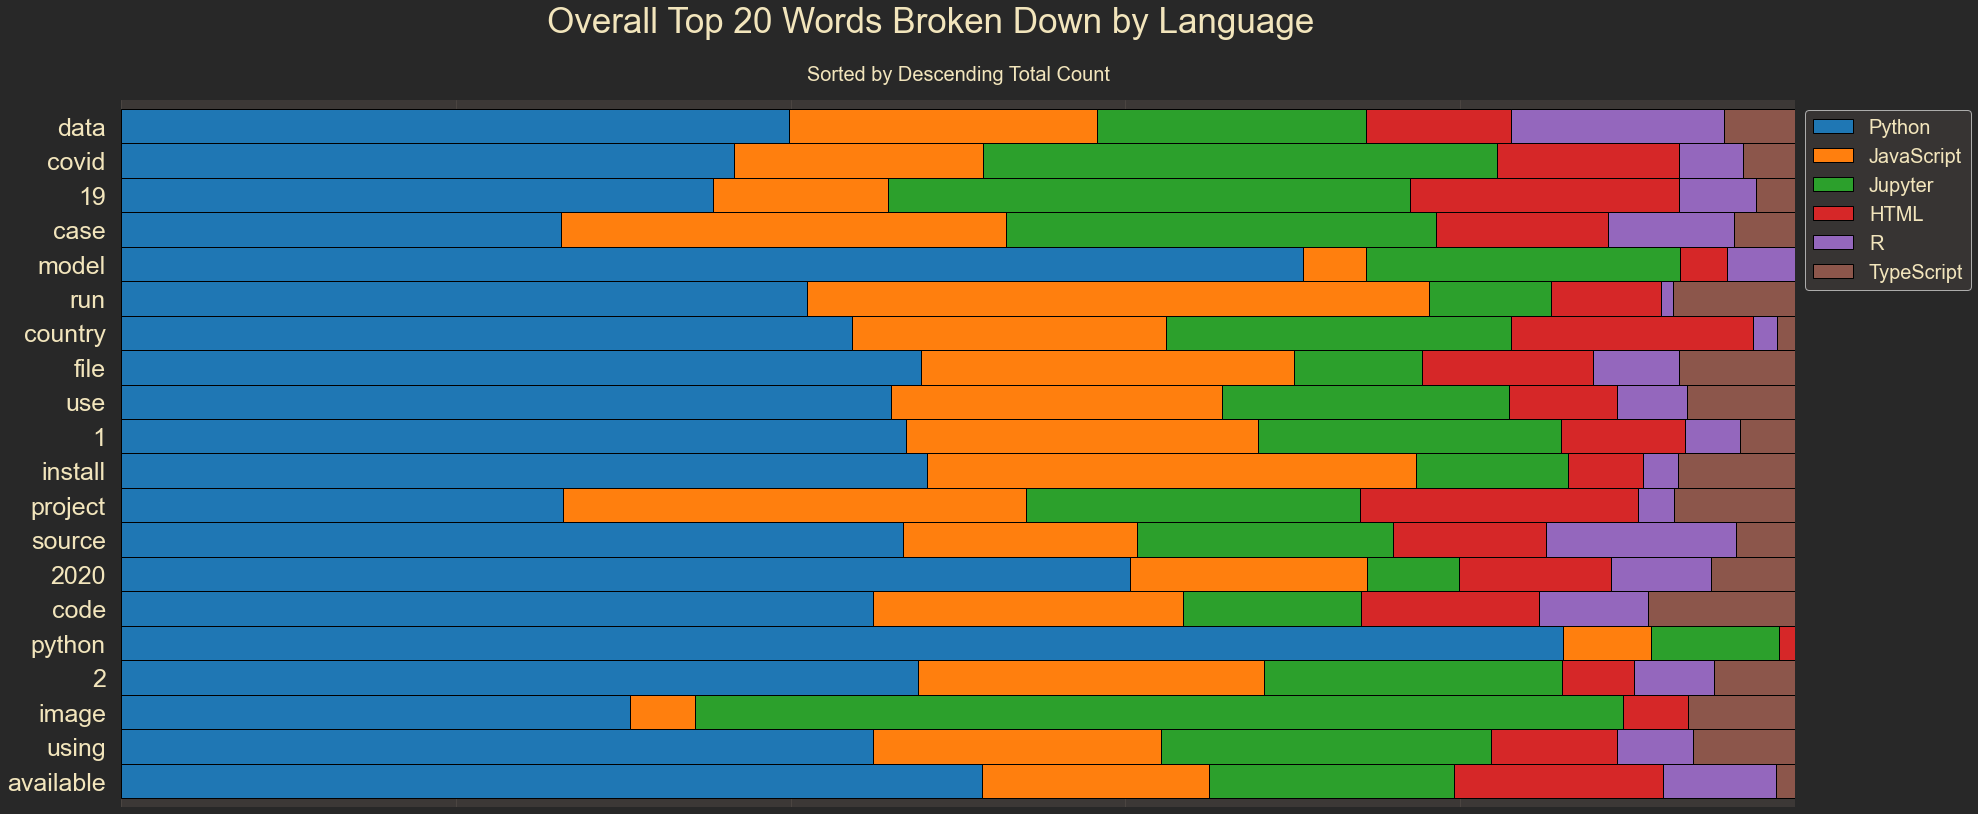

In [29]:
# visualize the percentage of each language to all words
fig, ax = plt.subplots(figsize=(30, 13))
top_20_word_freq.assign(pct_py=word_freq.py_words / word_freq.all_words,
                        pct_js=word_freq.js_words / word_freq.all_words,
                        pct_jup=word_freq.jup_words / word_freq.all_words,
                        pct_html=word_freq.html_words / word_freq.all_words,
                        pct_r=word_freq.r_words / word_freq.all_words,
                        pct_ts=word_freq.ts_words / word_freq.all_words)\
    .sort_values(by='all_words')\
    [['pct_py', 'pct_js', 'pct_jup', 'pct_html', 'pct_r', 'pct_ts']]\
    .plot.barh(stacked=True, ec='k', width=1, ax=ax)
ax.set_xlim(xmax=1)
ax.tick_params(axis='y', labelsize=25, pad=15)
plt.tick_params(axis='x', labelbottom=False)
ax.legend(labels=['Python', 'JavaScript', 'Jupyter', 'HTML', 'R', 'TypeScript'],
          bbox_to_anchor=(1,1), fontsize=20, frameon=True)
plt.suptitle('Overall Top 20 Words Broken Down by Language', fontsize=35)
plt.title('Sorted by Descending Total Count', fontsize=20, pad=20)
plt.show()

In [30]:
# find words common to all languages
common_words = [py_words, js_words, jup_words, html_words, r_words, ts_words]
common_words = list(reduce(lambda i, j: i & j, (set(n) for n in common_words)))
common_words = all_lang_words[all_lang_words.isin(common_words)]
common_freq = common_words.value_counts().sort_values(ascending=False)

# create DataFrame for word freq for all and per language
common_word_freq = pd.concat([common_freq,
                              py_words_freq,
                              js_words_freq,
                              jup_words_freq,
                              html_words_freq,
                              r_words_freq,
                              ts_words_freq],
                              axis=1,
                              sort=True)\
                     .set_axis(['common_words', 'py_words',
                                'js_words', 'jup_words',
                                'html_words', 'r_words',
                                'ts_words'], axis=1,
                                inplace=False)\
                     .fillna(0)\
                     .apply(lambda s: s.astype(int))

# subset word freq into top 20 all word frequencies
top_20_common_word_freq = common_word_freq.sort_values('common_words', ascending=False).head(20)

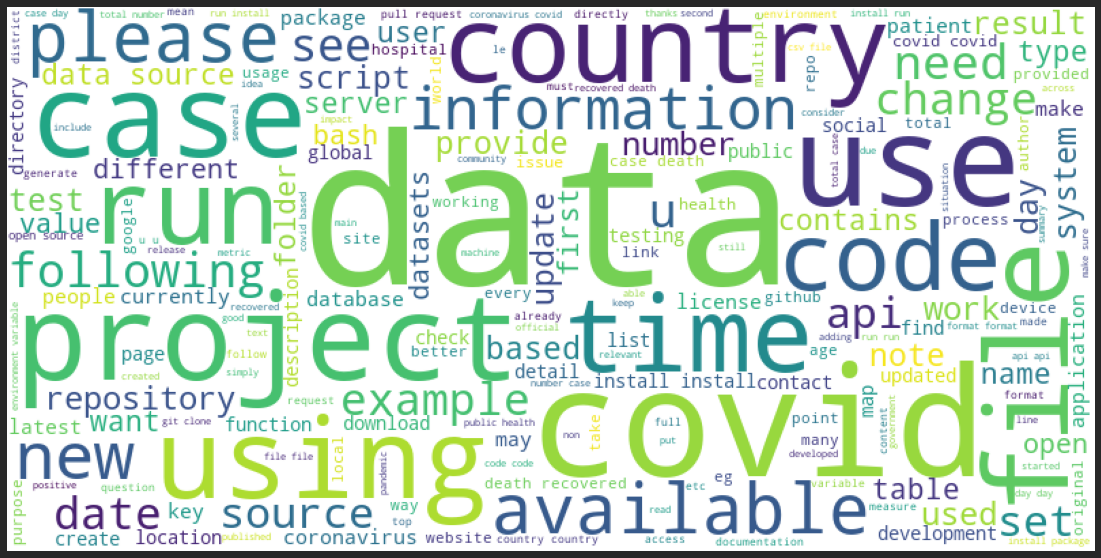

In [31]:
# visualize wordcloud of top 20 common words to all languages
img = WordCloud(background_color='white', width=800, height=400).generate(' '.join(common_words))
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

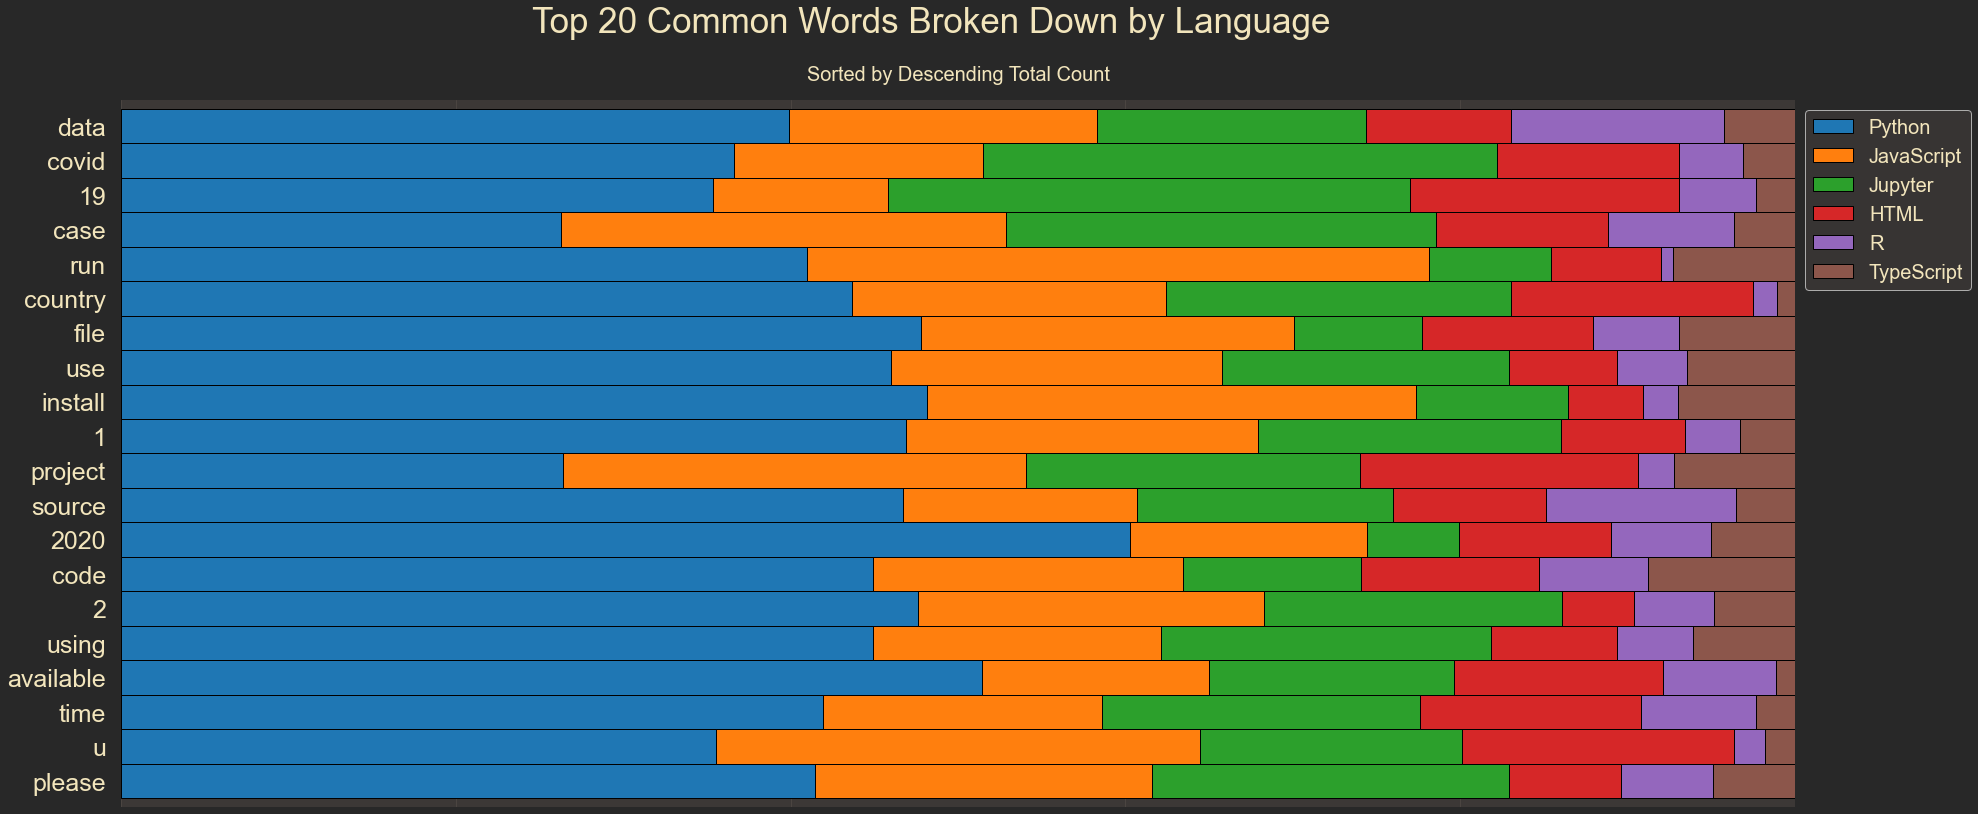

In [32]:
# visualize the percentage of each language to all words
fig, ax = plt.subplots(figsize=(30, 13))
top_20_common_word_freq.assign(pct_py=common_word_freq.py_words / common_word_freq.common_words,
                        pct_js=common_word_freq.js_words / common_word_freq.common_words,
                        pct_jup=common_word_freq.jup_words / common_word_freq.common_words,
                        pct_html=common_word_freq.html_words / common_word_freq.common_words,
                        pct_r=common_word_freq.r_words / common_word_freq.common_words,
                        pct_ts=common_word_freq.ts_words / common_word_freq.common_words)\
    .sort_values(by='common_words')\
    [['pct_py', 'pct_js', 'pct_jup', 'pct_html', 'pct_r', 'pct_ts']]\
    .plot.barh(stacked=True, ec='k', width=1, ax=ax)
ax.set_xlim(xmax=1)
ax.tick_params(axis='y', labelsize=25, pad=15)
plt.tick_params(axis='x', labelbottom=False)
ax.legend(labels=['Python', 'JavaScript', 'Jupyter', 'HTML', 'R', 'TypeScript'],
          bbox_to_anchor=(1,1), fontsize=20, frameon=True)
plt.suptitle('Top 20 Common Words Broken Down by Language', fontsize=35)
plt.title('Sorted by Descending Total Count', fontsize=20, pad=20)
plt.show()

In [33]:
# view which if any top 20 words are missing from languages


# top 20 words present in python readme
py_in_20 = top_20_words[top_20_words.index.isin(py_words)]
print(f'Python is missing {20 -len(py_in_20)} words: {list(set(top_20_words.index).difference(set(py_in_20.index)))}')
# top 20 words present in javascript readme
js_in_20 = top_20_words[top_20_words.index.isin(js_words)]
print(f'JavaScript is missing {20 -len(js_in_20)} words: {list(set(top_20_words.index).difference(set(js_in_20.index)))}')
# top 20 words present in jupyter readme
jup_in_20 = top_20_words[top_20_words.index.isin(jup_words)]
print(f'Jupyter is missing {20 -len(jup_in_20)} words: {list(set(top_20_words.index).difference(set(jup_in_20.index)))}')
# top 20 words present in html readme
html_in_20 = top_20_words[top_20_words.index.isin(html_words)]
print(f'HTML is missing {20 -len(html_in_20)} words: {list(set(top_20_words.index).difference(set(html_in_20.index)))}')
# top 20 words present in r readme
r_in_20 = top_20_words[top_20_words.index.isin(r_words)]
print(f'R is missing {20 -len(r_in_20)} words: {list(set(top_20_words.index).difference(set(r_in_20.index)))}')
# top 20 words present in typescript readme
ts_in_20 = top_20_words[top_20_words.index.isin(ts_words)]
print(f'Typescript is missing {20 -len(ts_in_20)} words: {list(set(top_20_words.index).difference(set(ts_in_20.index)))}')

Python is missing 0 words: []
JavaScript is missing 0 words: []
Jupyter is missing 0 words: []
HTML is missing 0 words: []
R is missing 2 words: ['image', 'python']
Typescript is missing 2 words: ['model', 'python']


In [34]:
# view which do not contain a top 20 in respective top 20


# python top 20 in total top 20
py_20_in_20 = top_20_words[top_20_words.index.isin(py_words.value_counts().sort_values().tail(20).index)]
print(f'Python is missing {20 -len(py_20_in_20)} words: {list(set(top_20_words.index).difference(set(py_20_in_20.index)))}')
# javescript top 20 in total top 20
js_20_in_20 = top_20_words[top_20_words.index.isin(js_words.value_counts().sort_values().tail(20).index)]
print(f'JavaScript is missing {20 -len(js_20_in_20)} words: {list(set(top_20_words.index).difference(set(js_20_in_20.index)))}')
# jupyter top 20 in total top 20
jup_20_in_20 = top_20_words[top_20_words.index.isin(jup_words.value_counts().sort_values().tail(20).index)]
print(f'Jupyter is missing {20 -len(jup_20_in_20)} words: {list(set(top_20_words.index).difference(set(jup_20_in_20.index)))}')
# html top 20 in total top 20
html_20_in_20 = top_20_words[top_20_words.index.isin(html_words.value_counts().sort_values().tail(20).index)]
print(f'HTML is missing {20 -len(html_20_in_20)} words: {list(set(top_20_words.index).difference(set(html_20_in_20.index)))}')
# r top 20 in total top 20
r_20_in_20 = top_20_words[top_20_words.index.isin(r_words.value_counts().sort_values().tail(20).index)]
print(f'R is missing {20 -len(r_20_in_20)} words: {list(set(top_20_words.index).difference(set(r_20_in_20.index)))}')
# typescript top 20 in total top 20
ts_20_in_20 = top_20_words[top_20_words.index.isin(ts_words.value_counts().sort_values().tail(20).index)]
print(f'Typescript is missing {20 -len(ts_20_in_20)} words: {list(set(top_20_words.index).difference(set(ts_20_in_20.index)))}')

Python is missing 2 words: ['project', 'image']
JavaScript is missing 8 words: ['model', '2020', 'image', 'python', 'code', 'source', 'using', 'available']
Jupyter is missing 8 words: ['run', '2020', 'python', 'install', 'source', 'file', 'code', 'available']
HTML is missing 10 words: ['model', 'run', '2020', '2', 'use', 'image', 'python', 'install', 'using', '1']
R is missing 11 words: ['run', 'use', '2', 'project', 'image', 'country', 'python', 'install', 'using', 'available', '1']
Typescript is missing 12 words: ['model', '2020', '2', 'image', 'country', 'python', 'available', 'source', 'using', 'case', '1', '19']


**Notes**

- Common individual words were largely related to subject matter of the repositories
    - i.e. COVID-19 and research therof
- Other words, such as "data", "source", and "using" provide little insights
    - "Model" and "Python" both directly relate to the most common class of `language`

#### Unique Words Per Language

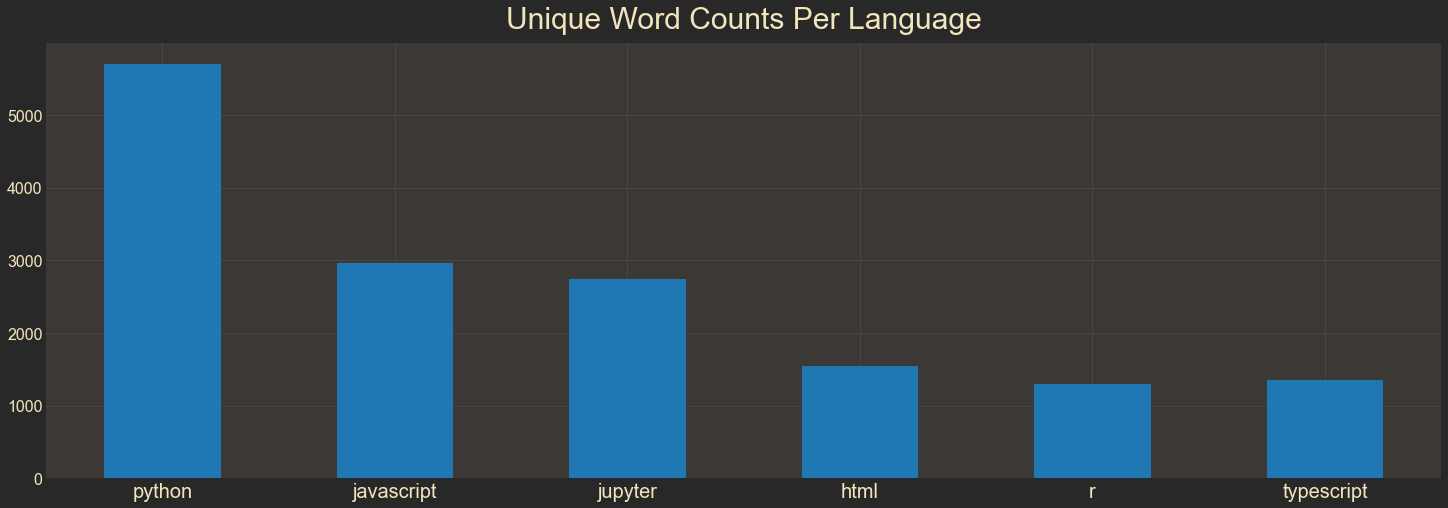

In [35]:
unique_word_counts = [{'python':len(set(' '.join(py_words).split()))},
                      {'javascript':len(set(' '.join(js_words).split()))},
                      {'jupyter':len(set(' '.join(jup_words).split()))},
                      {'html':len(set(' '.join(html_words).split()))},
                      {'r':len(set(' '.join(r_words).split()))},
                      {'typescript':len(set(' '.join(ts_words).split()))}]
pd.DataFrame([d.values() for d in unique_word_counts],
             index=[list(d.items())[0][0] for d in unique_word_counts],
             columns=['unique_word_count']).plot.bar(legend=None)
plt.xticks(rotation=0, fontsize=20)
plt.title('Unique Word Counts Per Language', fontsize=30, pad=15)
plt.show()

#### Differing Elements

In [36]:
# find words not in python
non_py_words = [js_words, jup_words, html_words, r_words, ts_words]
non_py_words = list(reduce(lambda i, j: i & j, (set(n) for n in non_py_words)))
# find words not in javascript
non_js_words = [py_words, jup_words, html_words, r_words, ts_words]
non_js_words = list(reduce(lambda i, j: i & j, (set(n) for n in non_js_words)))
# find words not in jupyter
non_jup_words = [py_words, js_words, html_words, r_words, ts_words]
non_jup_words = list(reduce(lambda i, j: i & j, (set(n) for n in non_jup_words)))
# find words not in html
non_html_words = [py_words, js_words, jup_words, r_words, ts_words]
non_html_words = list(reduce(lambda i, j: i & j, (set(n) for n in non_html_words)))
# find words not in r
non_r_words = [py_words, js_words, jup_words, r_words, ts_words]
non_r_words = list(reduce(lambda i, j: i & j, (set(n) for n in non_r_words)))
# find words not in typescript
non_ts_words = [py_words, js_words, jup_words, r_words, ts_words]
non_ts_words = list(reduce(lambda i, j: i & j, (set(n) for n in non_ts_words)))

In [37]:
# find top 20 python only words
py_only_words = py_words[py_words.isin(non_py_words) == False]
top_20_py_only_words = py_only_words.value_counts().sort_values(ascending=False).head(20)

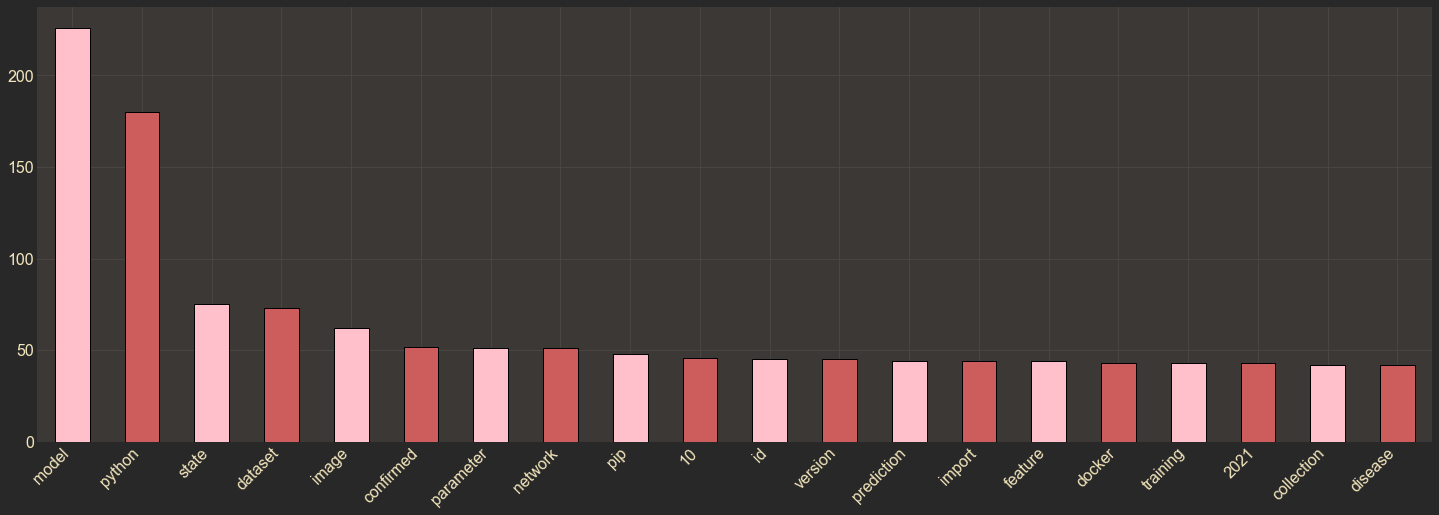

In [38]:
# visualize python only word single word counts
top_20_py_only_words.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

In [39]:
# find top 20 javascript only words
js_only_words = js_words[js_words.isin(non_js_words) == False]
top_20_js_only_words = js_only_words.value_counts().sort_values(ascending=False).head(20)

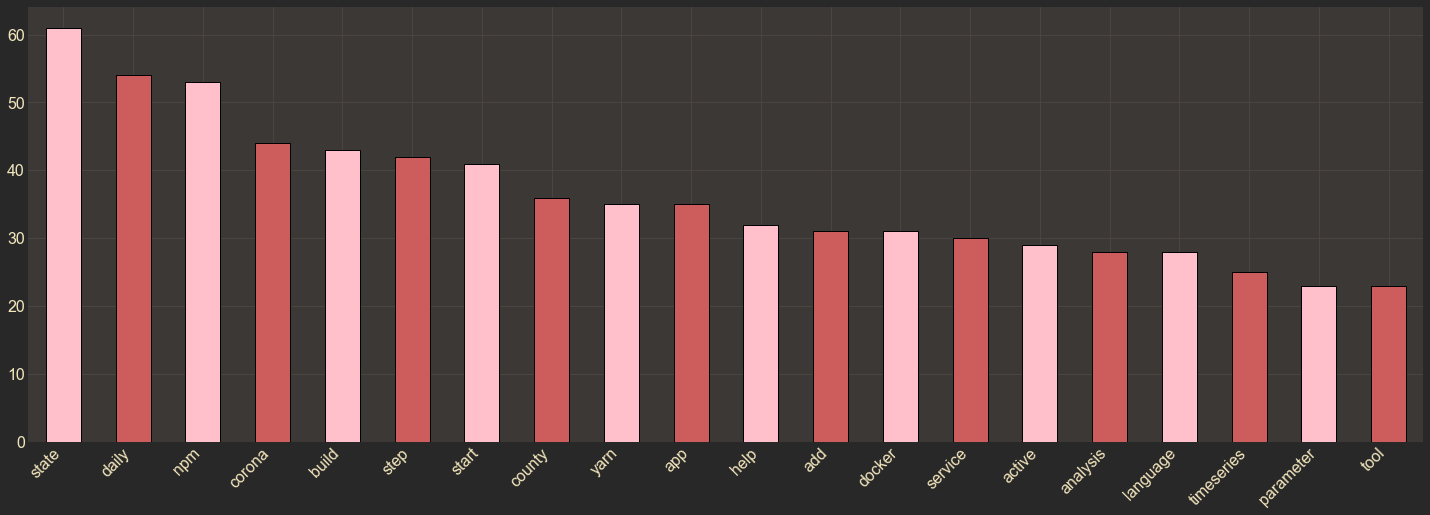

In [40]:
# visualize javascript only word single word counts
top_20_js_only_words.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

In [41]:
# find top 20 jupyter only words
jup_only_words = jup_words[jup_words.isin(non_jup_words) == False]
top_20_jup_only_words = jup_only_words.value_counts().sort_values(ascending=False).head(20)

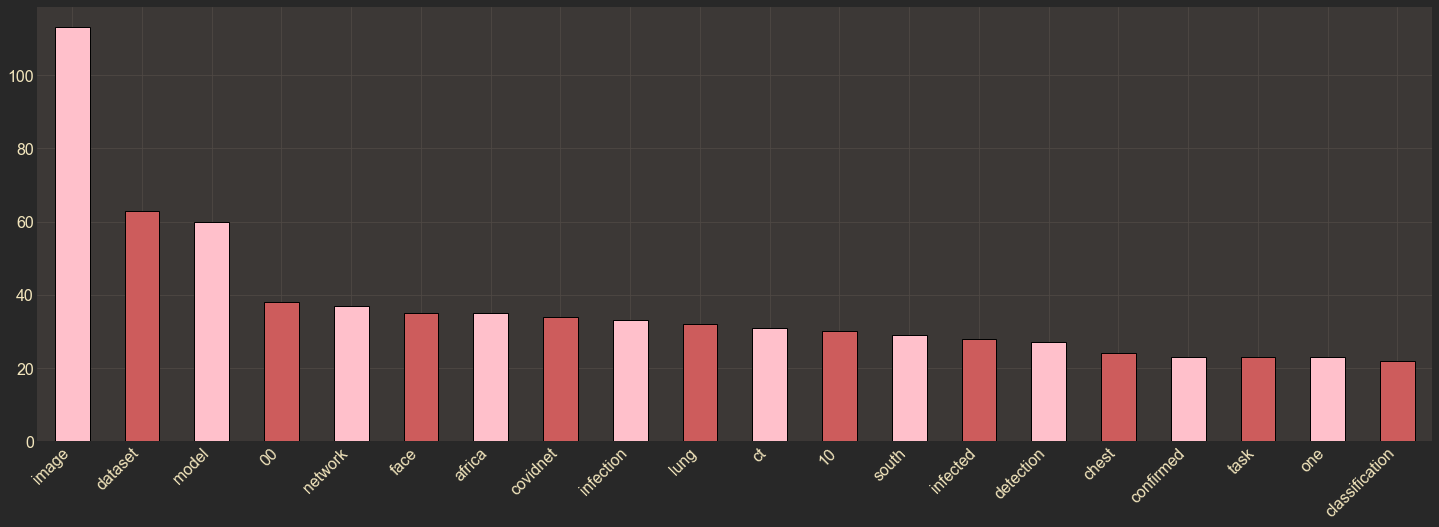

In [42]:
# visualize jupyter only word single word counts
top_20_jup_only_words.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

In [43]:
# find top 20 html only words
html_only_words = html_words[html_words.isin(non_html_words) == False]
top_20_html_only_words = html_only_words.value_counts().sort_values(ascending=False).head(20)

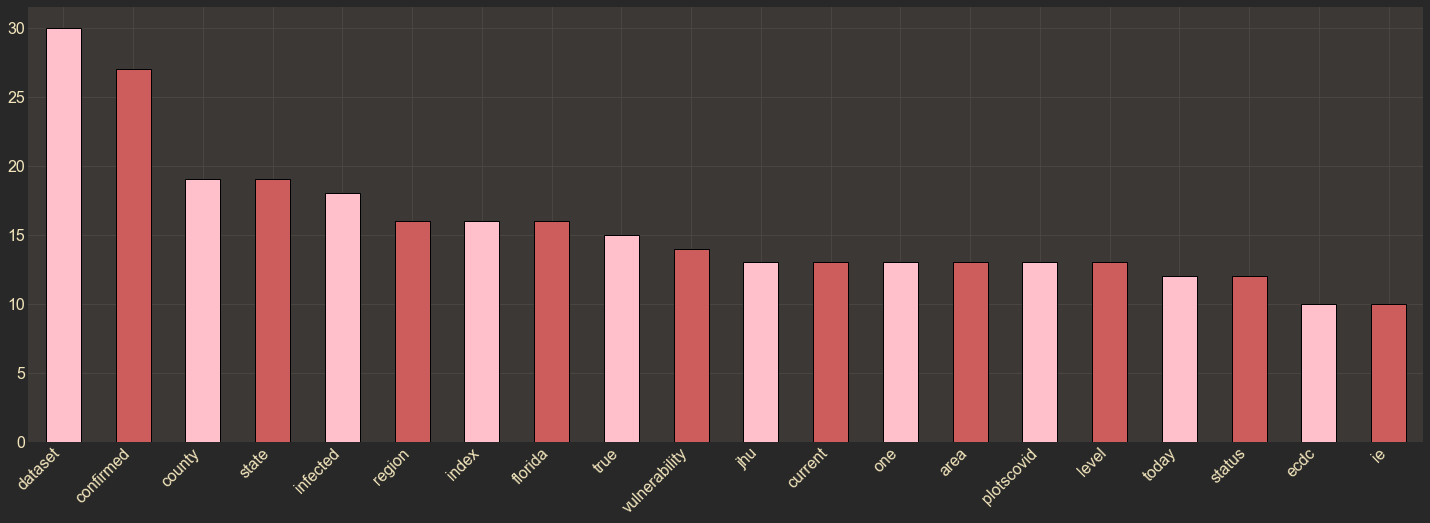

In [44]:
# visualize html only word single word counts
top_20_html_only_words.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

In [45]:
# find top 20 r only words
r_only_words = r_words[r_words.isin(non_r_words) == False]
top_20_r_only_words = r_only_words.value_counts().sort_values(ascending=False).head(20)

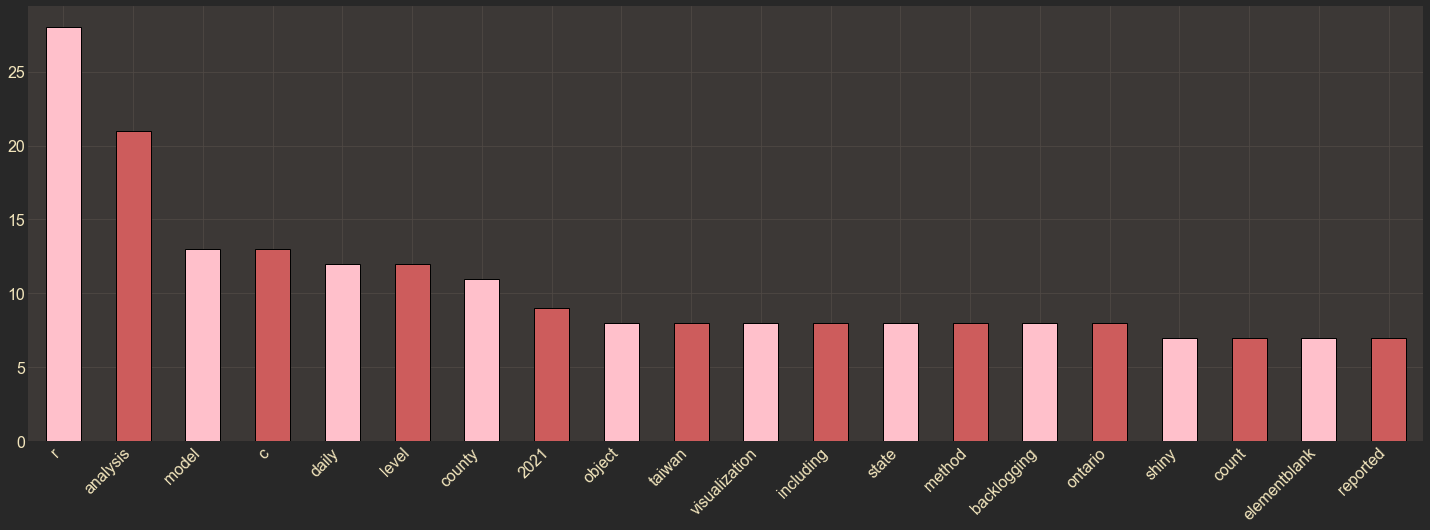

In [46]:
# visualize r only word single word counts
top_20_r_only_words.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

In [47]:
# find top 20 typescript only words
ts_only_words = ts_words[ts_words.isin(non_ts_words) == False]
top_20_ts_only_words = ts_only_words.value_counts().sort_values(ascending=False).head(20)

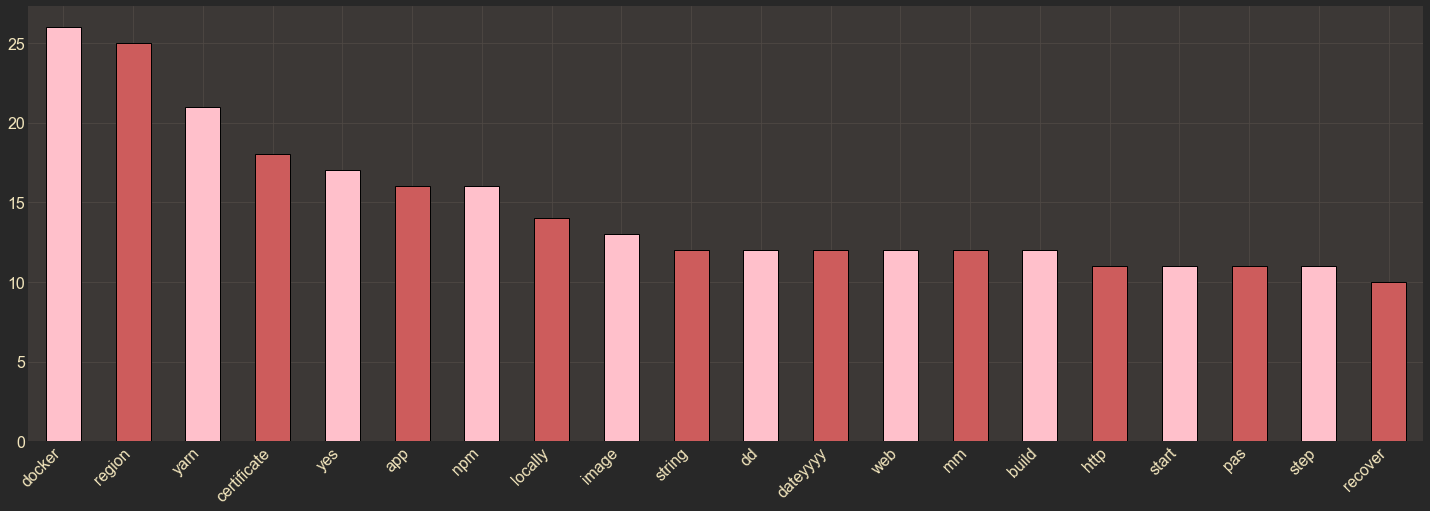

In [48]:
# visualize typescript only word single word counts
top_20_ts_only_words.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

#### Takeaways

- Certain languages made reference to specific locations much more often than others
    - i.e. "South"/"Africa" with Jupyter Notebook
- TypeScript made frequen reference to date formatting values, like "dd" and "mm"
- R and Python repositories made regular reference to their respective language

The common elements present in all or most contents will likely not play strong roles in class predictions, as they relate to subject matter for COVID-19.

### Bi-gram Frequencies

In [49]:
# create bigram freq series for all words and each language

# create series for all bigrams and frequency of
all_bigrams = pd.Series(nltk.bigrams(all_lang_words))
all_bigram_freq = all_bigrams.value_counts().sort_values(ascending=False)
top_20_bigrams = all_bigram_freq.head(20)
# create series for python bigrams and frequency of
py_bigrams = pd.Series(nltk.bigrams(py_words))
py_bigram_freq= py_bigrams.value_counts().sort_values(ascending=False)
# create series for javascript bigrams and frequency of
js_bigrams = pd.Series(nltk.bigrams(js_words))
js_bigram_freq = js_bigrams.value_counts().sort_values(ascending=False)
# create series for jupyter bigrams and frequency of
jup_bigrams = pd.Series(nltk.bigrams(jup_words))
jup_bigram_freq = jup_bigrams.value_counts().sort_values(ascending=False)
# create series for html bigrams and frequency of
html_bigrams = pd.Series(nltk.bigrams(html_words))
html_bigram_freq = html_bigrams.value_counts().sort_values(ascending=False)
# create series for r bigrams and frequency of
r_bigrams = pd.Series(nltk.bigrams(r_words))
r_bigram_freq = r_bigrams.value_counts().sort_values(ascending=False)
# create series for typescript bigrams and frequency of
ts_bigrams = pd.Series(nltk.bigrams(ts_words))
ts_bigram_freq = ts_bigrams.value_counts().sort_values(ascending=False)

#### Common Elements

In [50]:
# create DataFrame for bigram freq for all and per language
bigram_freq = pd.concat([all_bigram_freq,
                        py_bigram_freq,
                        js_bigram_freq,
                        jup_bigram_freq,
                        html_bigram_freq,
                        r_bigram_freq,
                        ts_bigram_freq],
                        axis=1,
                        sort=True)\
                .set_axis(['all_bigrams', 'py_bigrams',
                           'js_bigrams', 'jup_bigrams',
                           'html_bigrams', 'r_bigrams',
                           'ts_bigrams'], axis=1,
                           inplace=False)\
                .fillna(0)\
                .apply(lambda s: s.astype(int))
# subset word freq into top 20 all bigram frequencies
top_20_bigram_freq = bigram_freq.sort_values('all_bigrams', ascending=False).head(20)

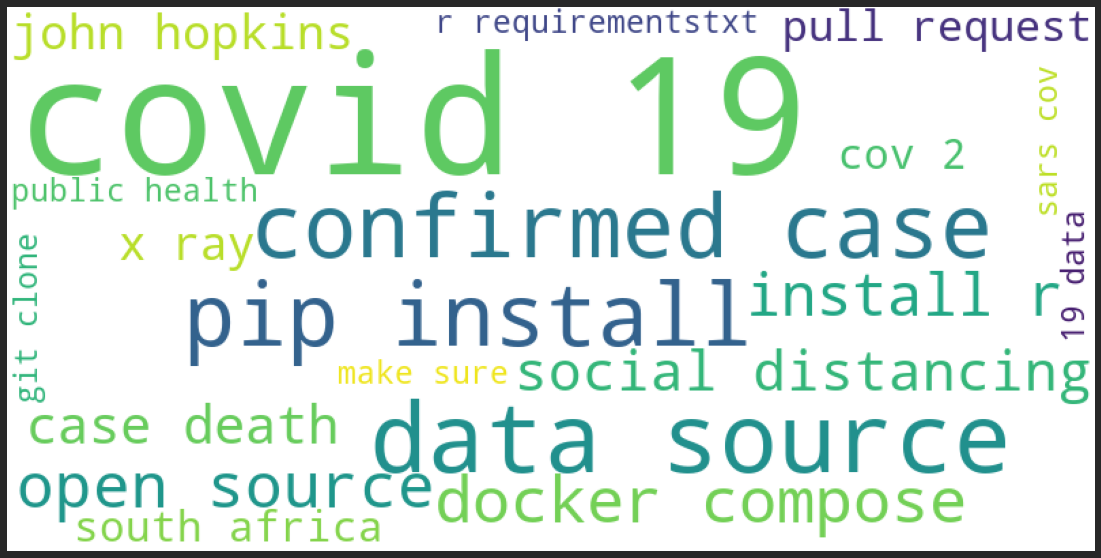

In [51]:
# visualize wordcloud of top 20 overall bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_20_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

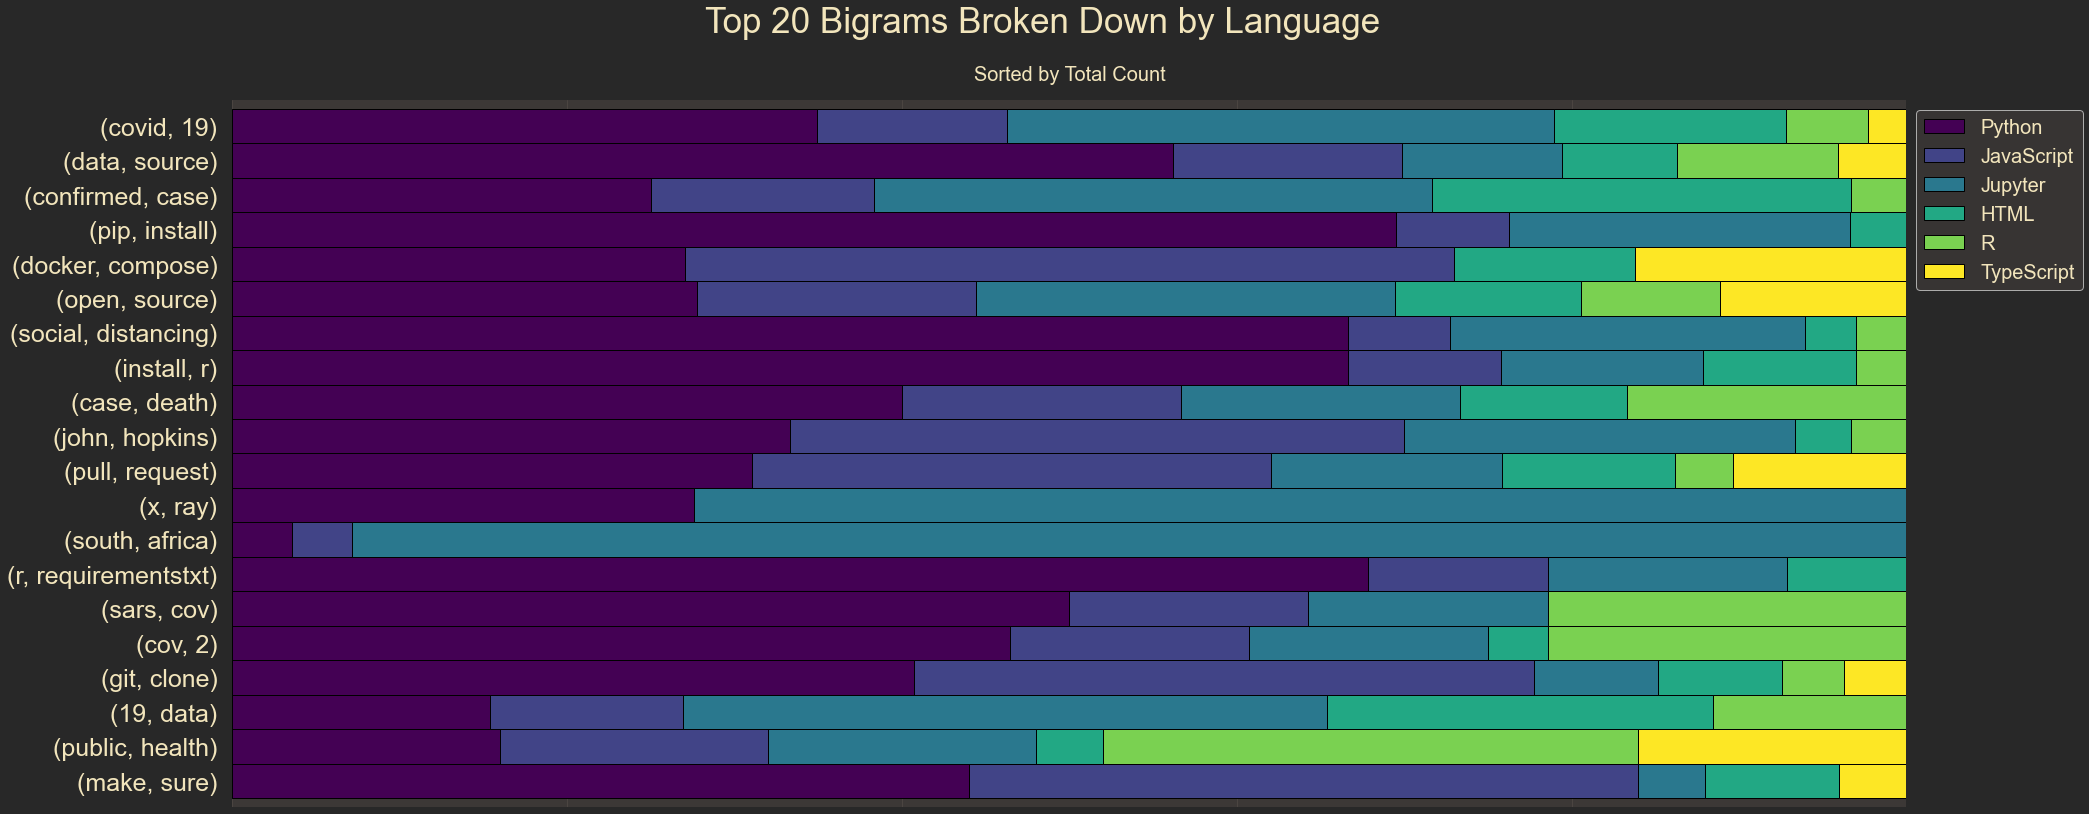

In [52]:
# visualize the percentage of each language to all bigrams
fig, ax = plt.subplots(figsize=(30, 13))
top_20_bigram_freq.assign(pct_py=bigram_freq.py_bigrams / bigram_freq.all_bigrams,
                        pct_js=bigram_freq.js_bigrams / bigram_freq.all_bigrams,
                        pct_jup=bigram_freq.jup_bigrams / bigram_freq.all_bigrams,
                        pct_html=bigram_freq.html_bigrams / bigram_freq.all_bigrams,
                        pct_r=bigram_freq.r_bigrams / bigram_freq.all_bigrams,
                        pct_ts=bigram_freq.ts_bigrams / bigram_freq.all_bigrams)\
    .sort_values(by='all_bigrams')\
    [['pct_py', 'pct_js', 'pct_jup', 'pct_html', 'pct_r', 'pct_ts']]\
    .plot.barh(stacked=True, ec='k', width=1, ax=ax, cmap='viridis')
ax.set_xlim(xmax=1)
ax.tick_params(axis='y', labelsize=25, pad=15)
plt.tick_params(axis='x', labelbottom=False)
ax.legend(labels=['Python', 'JavaScript', 'Jupyter', 'HTML', 'R', 'TypeScript'],
          bbox_to_anchor=(1,1), fontsize=20, frameon=True)
plt.suptitle('Top 20 Bigrams Broken Down by Language', fontsize=35)
plt.title('Sorted by Total Count', fontsize=20, pad=20)
plt.show()

all_bigrams = pd.Series(bigram for bigram in [f'{gram[0]} {gram[1]}' for gram in all_bigrams])
py_bigrams = pd.Series(bigram for bigram in [f'{gram[0]} {gram[1]}' for gram in py_bigrams])
js_bigrams = pd.Series(bigram for bigram in [f'{gram[0]} {gram[1]}' for gram in js_bigrams])
jup_bigrams = pd.Series(bigram for bigram in [f'{gram[0]} {gram[1]}' for gram in jup_bigrams])
html_bigrams = pd.Series(bigram for bigram in [f'{gram[0]} {gram[1]}' for gram in html_bigrams])
r_bigrams = pd.Series(bigram for bigram in [f'{gram[0]} {gram[1]}' for gram in r_bigrams])
ts_bigrams = pd.Series(bigram for bigram in [f'{gram[0]} {gram[1]}' for gram in ts_bigrams])

In [53]:
# find bigrams common to all languages
common_bigrams = [py_bigrams, js_bigrams, jup_bigrams, html_bigrams, r_bigrams, ts_bigrams]
common_bigrams = list(reduce(lambda i, j: i & j, (set(n) for n in common_bigrams)))
common_bigrams = all_bigrams[all_bigrams.isin(common_bigrams)]
common_freq = common_bigrams.value_counts().sort_values(ascending=False)

# create DataFrame for bigram freq for all and per language
common_bi_freq = pd.concat([common_freq,
                              py_bigram_freq,
                              js_bigram_freq,
                              jup_bigram_freq,
                              html_bigram_freq,
                              r_bigram_freq,
                              ts_bigram_freq],
                              axis=1,
                              sort=True)\
                     .set_axis(['common_bigrams', 'py_bigrams',
                                'js_bigrams', 'jup_bigrams',
                                'html_bigrams', 'r_bigrams',
                                'ts_bigrams'], axis=1,
                                inplace=False)\
                     .fillna(0)\
                     .apply(lambda s: s.astype(int))

# subset word freq into six all bigram frequencies
common_bi_freq = common_bi_freq.sort_values('common_bigrams', ascending=False).head(6)

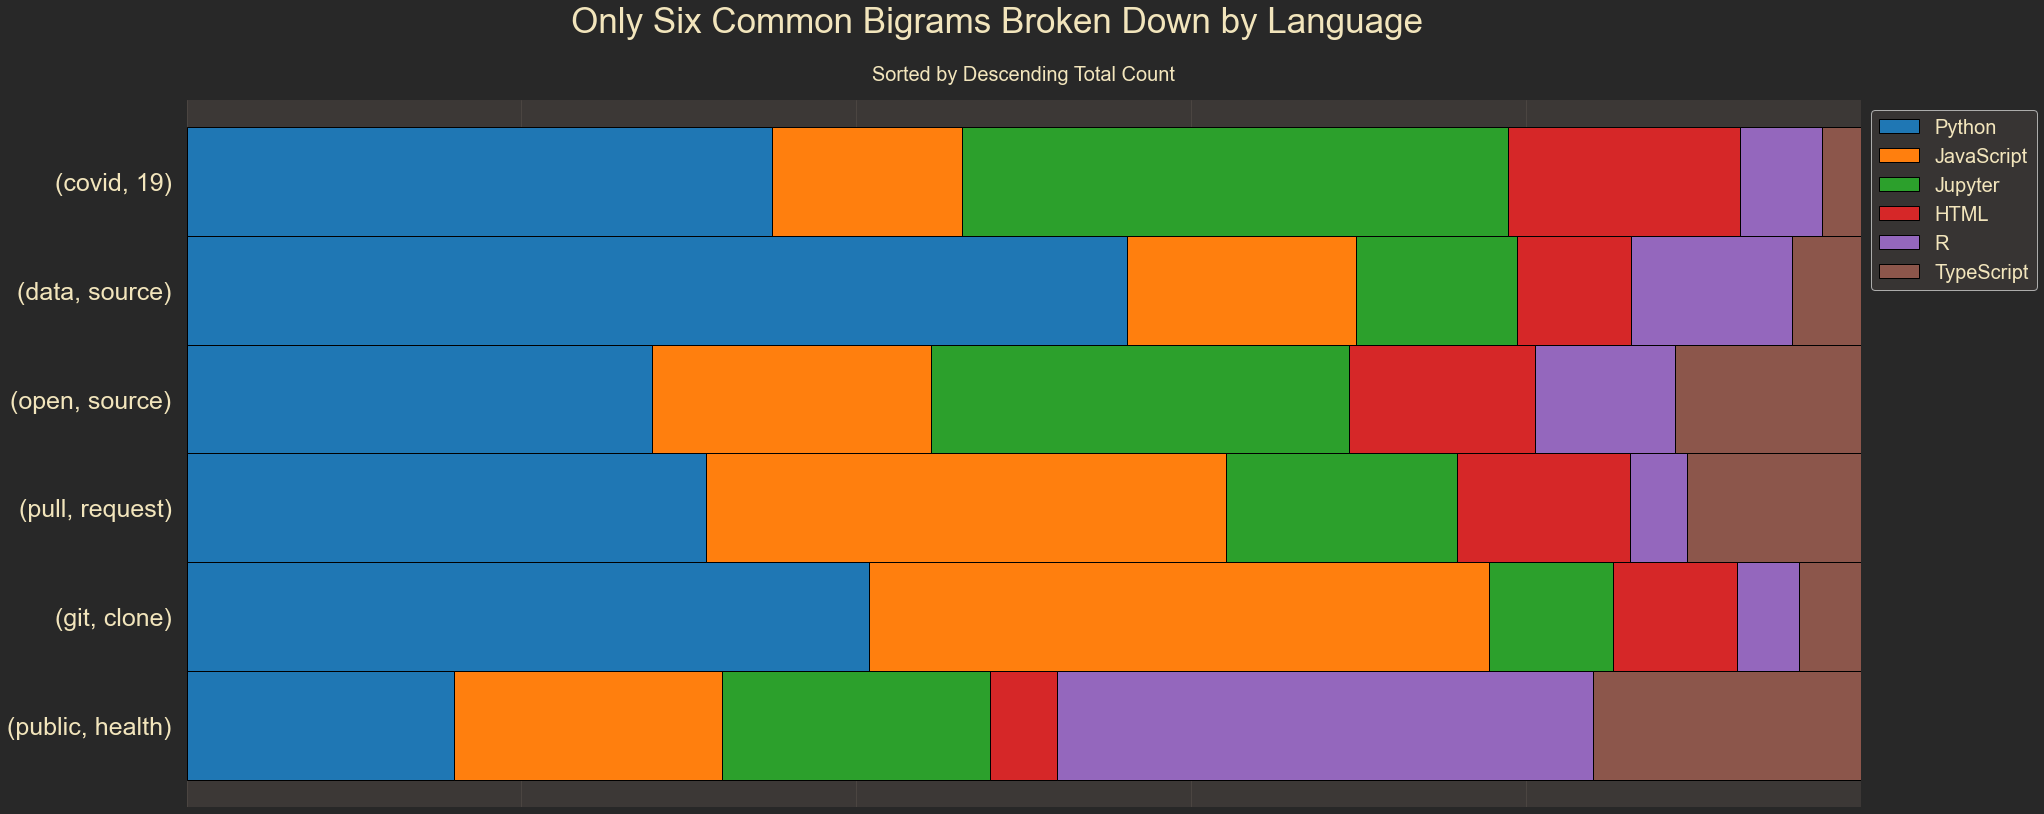

In [54]:
# visualize the percentage of each language for common bigrams
fig, ax = plt.subplots(figsize=(30, 13))
common_bi_freq.assign(pct_py=common_bi_freq.py_bigrams     / common_bi_freq.common_bigrams,
                      pct_js=common_bi_freq.js_bigrams     / common_bi_freq.common_bigrams,
                      pct_jup=common_bi_freq.jup_bigrams   / common_bi_freq.common_bigrams,
                      pct_html=common_bi_freq.html_bigrams / common_bi_freq.common_bigrams,
                      pct_r=common_bi_freq.r_bigrams       / common_bi_freq.common_bigrams,
                      pct_ts=common_bi_freq.ts_bigrams     / common_bi_freq.common_bigrams)\
    .sort_values(by='common_bigrams')\
    [['pct_py', 'pct_js', 'pct_jup', 'pct_html', 'pct_r', 'pct_ts']]\
    .plot.barh(stacked=True, ec='k', width=1, ax=ax)
ax.set_xlim(xmax=1)
ax.tick_params(axis='y', labelsize=25, pad=15)
plt.tick_params(axis='x', labelbottom=False)
ax.legend(labels=['Python', 'JavaScript', 'Jupyter', 'HTML', 'R', 'TypeScript'],
          bbox_to_anchor=(1,1), fontsize=20, frameon=True)
plt.suptitle('Only Six Common Bigrams Broken Down by Language', fontsize=35)
plt.title('Sorted by Descending Total Count', fontsize=20, pad=20)
plt.show()

In [55]:
# view which if any top 20 bigrams are missing from languages


# top 20 bigrams present in python readme
py_in_20 = top_20_bigrams[top_20_bigrams.index.isin(py_bigrams)]
print(f'Python is missing {20 -len(py_in_20)} bigram(s): {list(set(top_20_bigrams.index).difference(set(py_in_20.index)))}')
# top 20 bigrams present in javascript readme
js_in_20 = top_20_bigrams[top_20_bigrams.index.isin(js_bigrams)]
print(f'JavaScript is missing {20 -len(js_in_20)} bigram(s): {list(set(top_20_bigrams.index).difference(set(js_in_20.index)))}')
# top 20 words present in jupyter readme
jup_in_20 = top_20_bigrams[top_20_bigrams.index.isin(jup_bigrams)]
print(f'Jupyter is missing {20 -len(jup_in_20)} bigram(s): {list(set(top_20_bigrams.index).difference(set(jup_in_20.index)))}')
# top 20 words present in html readme
html_in_20 = top_20_bigrams[top_20_bigrams.index.isin(html_bigrams)]
print(f'HTML is missing {20 -len(html_in_20)} bigram(s): {list(set(top_20_bigrams.index).difference(set(html_in_20.index)))}')
# top 20 words present in r readme
r_in_20 = top_20_bigrams[top_20_bigrams.index.isin(r_bigrams)]
print(f'R is missing {20 -len(r_in_20)} bigram(s): {list(set(top_20_bigrams.index).difference(set(r_in_20.index)))}')
# top 20 words present in typescript readme
ts_in_20 = top_20_bigrams[top_20_bigrams.index.isin(ts_bigrams)]
print(f'TypeSscript is missing {20 -len(ts_in_20)} bigram(s): {list(set(top_20_bigrams.index).difference(set(ts_in_20.index)))}')

Python is missing 0 bigram(s): []
JavaScript is missing 1 bigram(s): [('x', 'ray')]
Jupyter is missing 1 bigram(s): [('docker', 'compose')]
HTML is missing 3 bigram(s): [('x', 'ray'), ('sars', 'cov'), ('south', 'africa')]
R is missing 6 bigram(s): [('docker', 'compose'), ('south', 'africa'), ('x', 'ray'), ('r', 'requirementstxt'), ('pip', 'install'), ('make', 'sure')]
TypeSscript is missing 12 bigram(s): [('confirmed', 'case'), ('cov', '2'), ('social', 'distancing'), ('sars', 'cov'), ('south', 'africa'), ('x', 'ray'), ('john', 'hopkins'), ('case', 'death'), ('r', 'requirementstxt'), ('pip', 'install'), ('19', 'data'), ('install', 'r')]


In [56]:
# view which do not contain a top 20 in respective top 20


# python top 20 in total top 20
py_20_in_20 = top_20_bigrams[top_20_bigrams.index.isin(py_bigrams.value_counts().sort_values().tail(20).index)]
print(f'Python is missing {20 -len(py_20_in_20)} bigram(s): {list(set(top_20_bigrams.index).difference(set(py_20_in_20.index)))}\n')
# javescript top 20 in total top 20
js_20_in_20 = top_20_bigrams[top_20_bigrams.index.isin(js_bigrams.value_counts().sort_values().tail(20).index)]
print(f'JavaScript is missing {20 -len(js_20_in_20)} bigram(s): {list(set(top_20_bigrams.index).difference(set(js_20_in_20.index)))}\n')
# jupyter top 20 in total top 20
jup_20_in_20 = top_20_bigrams[top_20_bigrams.index.isin(jup_bigrams.value_counts().sort_values().tail(20).index)]
print(f'Jupyter is missing {20 -len(jup_20_in_20)} bigram(s): {list(set(top_20_bigrams.index).difference(set(jup_20_in_20.index)))}\n')
# html top 20 in total top 20
html_20_in_20 = top_20_bigrams[top_20_bigrams.index.isin(html_bigrams.value_counts().sort_values().tail(20).index)]
print(f'HTML is missing {20 -len(html_20_in_20)} bigram(s): {list(set(top_20_bigrams.index).difference(set(html_20_in_20.index)))}\n')
# r top 20 in total top 20
r_20_in_20 = top_20_bigrams[top_20_bigrams.index.isin(r_bigrams.value_counts().sort_values().tail(20).index)]
print(f'R is missing {20 -len(r_20_in_20)} bigram(s): {list(set(top_20_bigrams.index).difference(set(r_20_in_20.index)))}\n')
# typescript top 20 in total top 20
ts_20_in_20 = top_20_bigrams[top_20_bigrams.index.isin(ts_bigrams.value_counts().sort_values().tail(20).index)]
print(f'TypeScript is missing {20 -len(ts_20_in_20)} bigram(s): {list(set(top_20_bigrams.index).difference(set(ts_20_in_20.index)))}\n')

Python is missing 10 bigram(s): [('docker', 'compose'), ('open', 'source'), ('git', 'clone'), ('x', 'ray'), ('south', 'africa'), ('john', 'hopkins'), ('pull', 'request'), ('make', 'sure'), ('19', 'data'), ('public', 'health')]

JavaScript is missing 14 bigram(s): [('confirmed', 'case'), ('cov', '2'), ('install', 'r'), ('social', 'distancing'), ('open', 'source'), ('sars', 'cov'), ('x', 'ray'), ('south', 'africa'), ('case', 'death'), ('r', 'requirementstxt'), ('pull', 'request'), ('pip', 'install'), ('19', 'data'), ('public', 'health')]

Jupyter is missing 13 bigram(s): [('cov', '2'), ('install', 'r'), ('docker', 'compose'), ('sars', 'cov'), ('social', 'distancing'), ('git', 'clone'), ('data', 'source'), ('john', 'hopkins'), ('case', 'death'), ('r', 'requirementstxt'), ('pull', 'request'), ('make', 'sure'), ('public', 'health')]

HTML is missing 17 bigram(s): [('open', 'source'), ('r', 'requirementstxt'), ('make', 'sure'), ('public', 'health'), ('cov', '2'), ('docker', 'compose'), ('soc

#### Differing Elements

In [57]:
# find bigrams not in python
non_py_bigrams = [js_bigrams, jup_bigrams, html_bigrams, r_bigrams, ts_bigrams]
non_py_bigrams = list(reduce(lambda i, j: i & j, (set(n) for n in non_py_bigrams)))
# find bigrams not in javascript
non_js_bigrams = [py_bigrams, jup_bigrams, html_bigrams, r_bigrams, ts_bigrams]
non_js_bigrams = list(reduce(lambda i, j: i & j, (set(n) for n in non_js_bigrams)))
# find bigrams not in jupyter
non_jup_bigrams = [py_bigrams, js_bigrams, html_bigrams, r_bigrams, ts_bigrams]
non_jup_bigrams = list(reduce(lambda i, j: i & j, (set(n) for n in non_jup_bigrams)))
# find bigrams not in html
non_html_bigrams = [py_bigrams, js_bigrams, jup_bigrams, r_bigrams, ts_bigrams]
non_html_bigrams = list(reduce(lambda i, j: i & j, (set(n) for n in non_html_bigrams)))
# find bigrams not in r
non_r_bigrams = [py_bigrams, js_bigrams, jup_bigrams, r_bigrams, ts_bigrams]
non_r_bigrams = list(reduce(lambda i, j: i & j, (set(n) for n in non_r_bigrams)))
# find bigrams not in typescript
non_ts_bigrams = [py_bigrams, js_bigrams, jup_bigrams, r_bigrams, ts_bigrams]
non_ts_bigrams = list(reduce(lambda i, j: i & j, (set(n) for n in non_ts_bigrams)))

In [58]:
# find top 20 python only bigrams
py_only_bigrams = py_bigrams[py_bigrams.isin(non_py_bigrams) == False]
top_20_py_only_bigrams = py_only_bigrams.value_counts().sort_values(ascending=False).head(20)

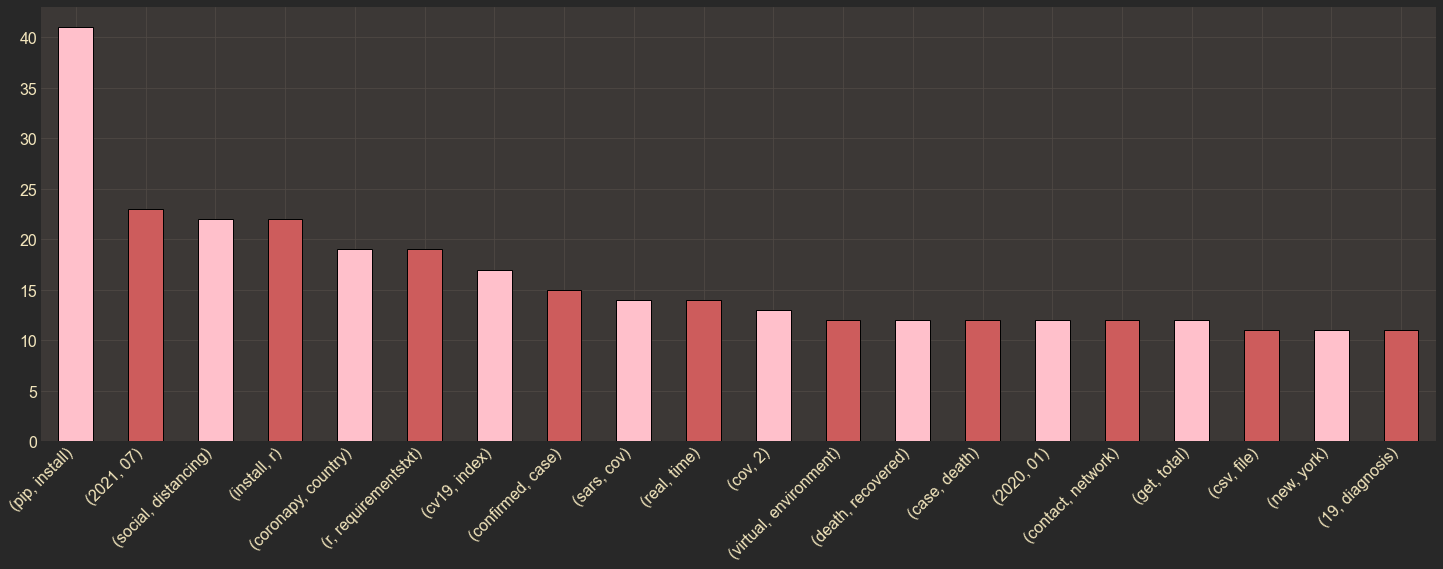

In [59]:
# visualize python only bigrams counts
top_20_py_only_bigrams.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

In [60]:
# find top 20 javascript only bigrams
js_only_bigrams = js_bigrams[js_bigrams.isin(non_js_bigrams) == False]
top_20_js_only_bigrams = js_only_bigrams.value_counts().sort_values(ascending=False).head(20)

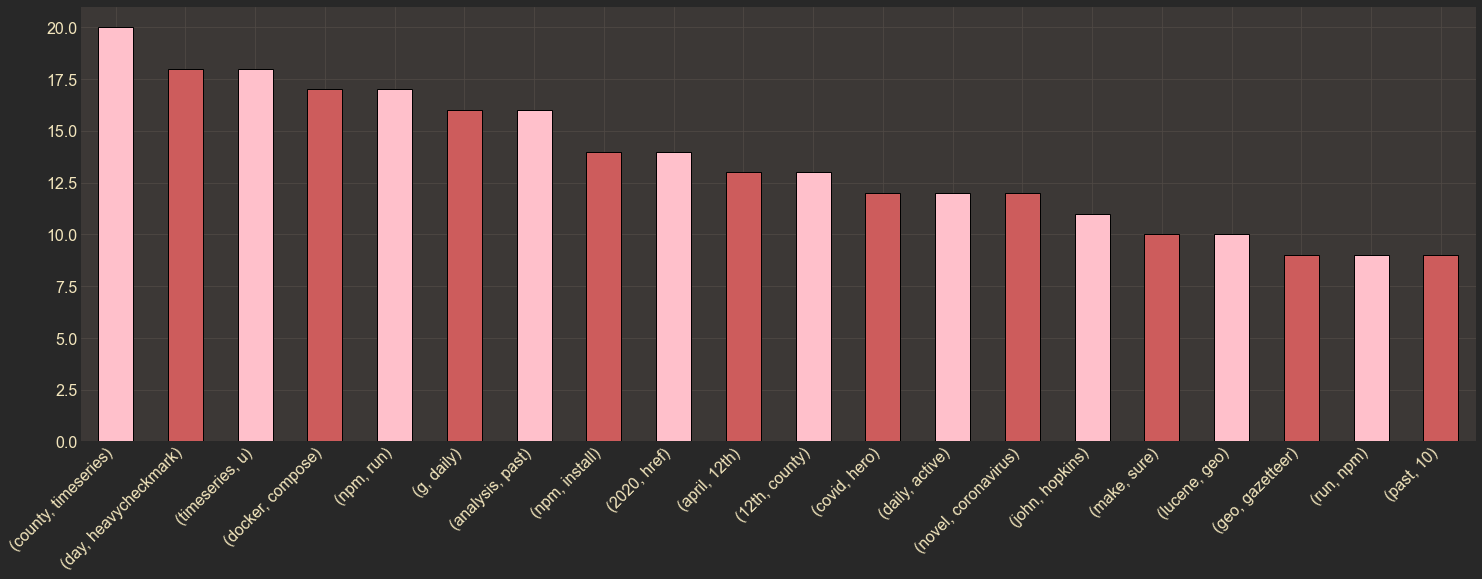

In [61]:
# visualize javascript only bigrams counts
top_20_js_only_bigrams.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

In [62]:
# find top 20 jupyter only bigrams
jup_only_bigrams = jup_bigrams[jup_bigrams.isin(non_jup_bigrams) == False]
top_20_jup_only_bigrams = jup_only_bigrams.value_counts().sort_values(ascending=False).head(20)

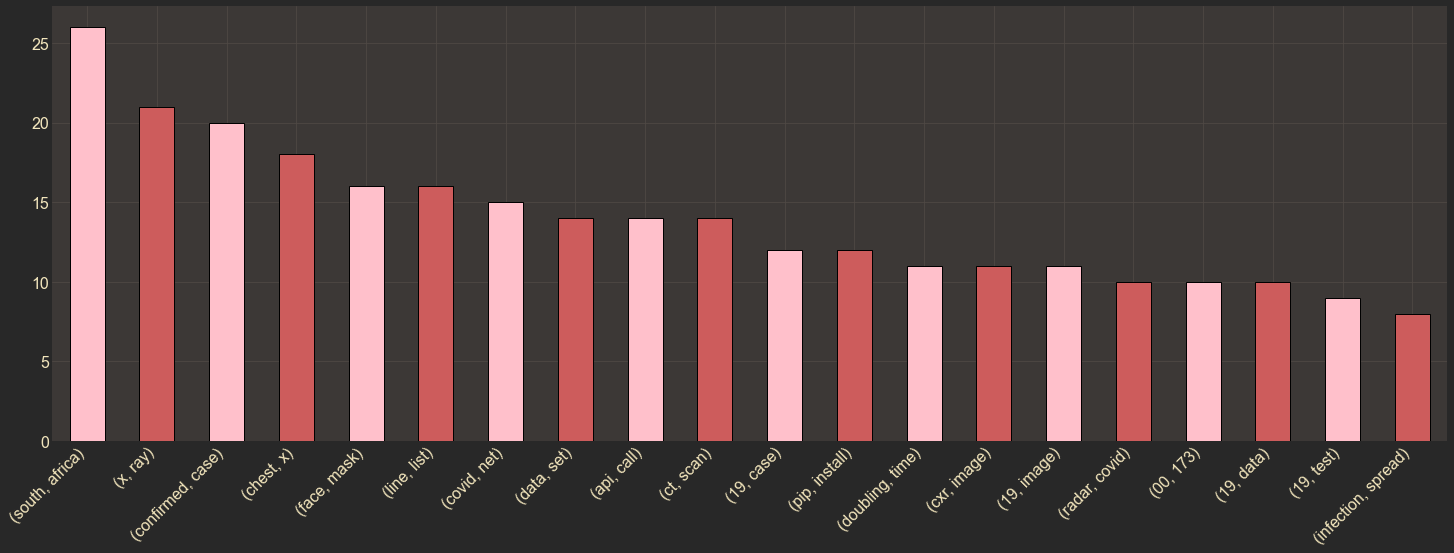

In [63]:
# visualize jupyter only bigrams counts
top_20_jup_only_bigrams.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

In [64]:
# find top 20 html only bigrams
html_only_bigrams = html_bigrams[html_bigrams.isin(non_html_bigrams) == False]
top_20_html_only_bigrams = html_only_bigrams.value_counts().sort_values(ascending=False).head(20)

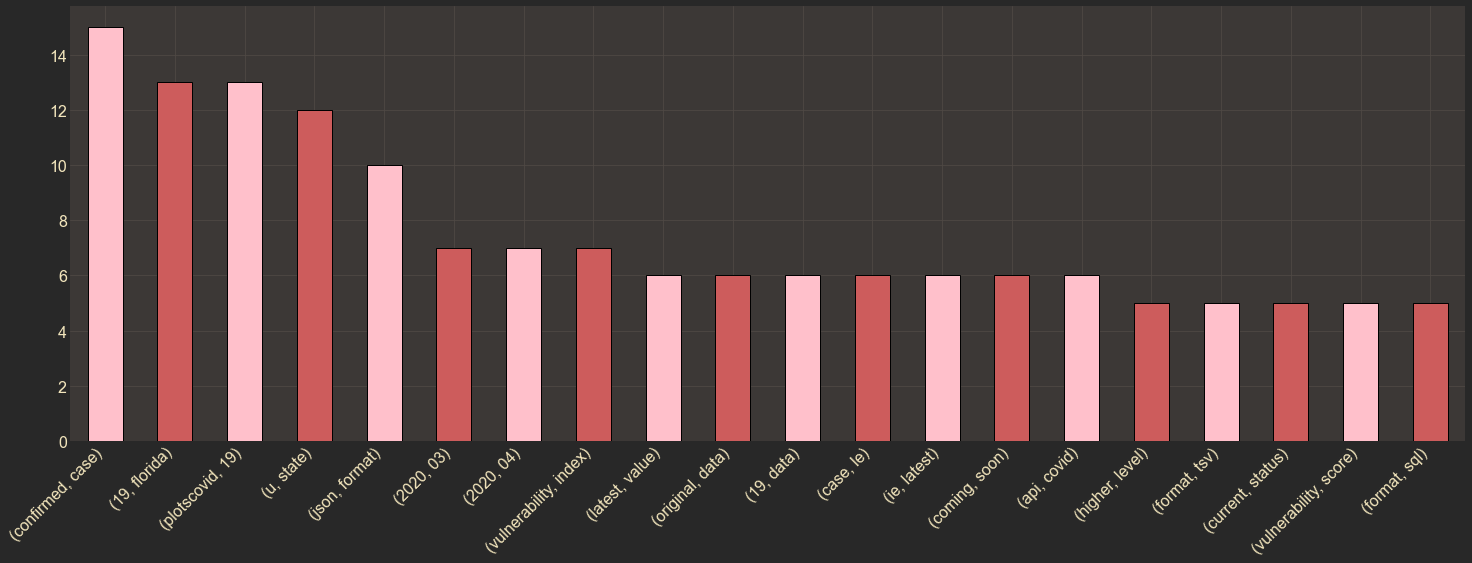

In [65]:
# visualize html only bigrams counts
top_20_html_only_bigrams.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

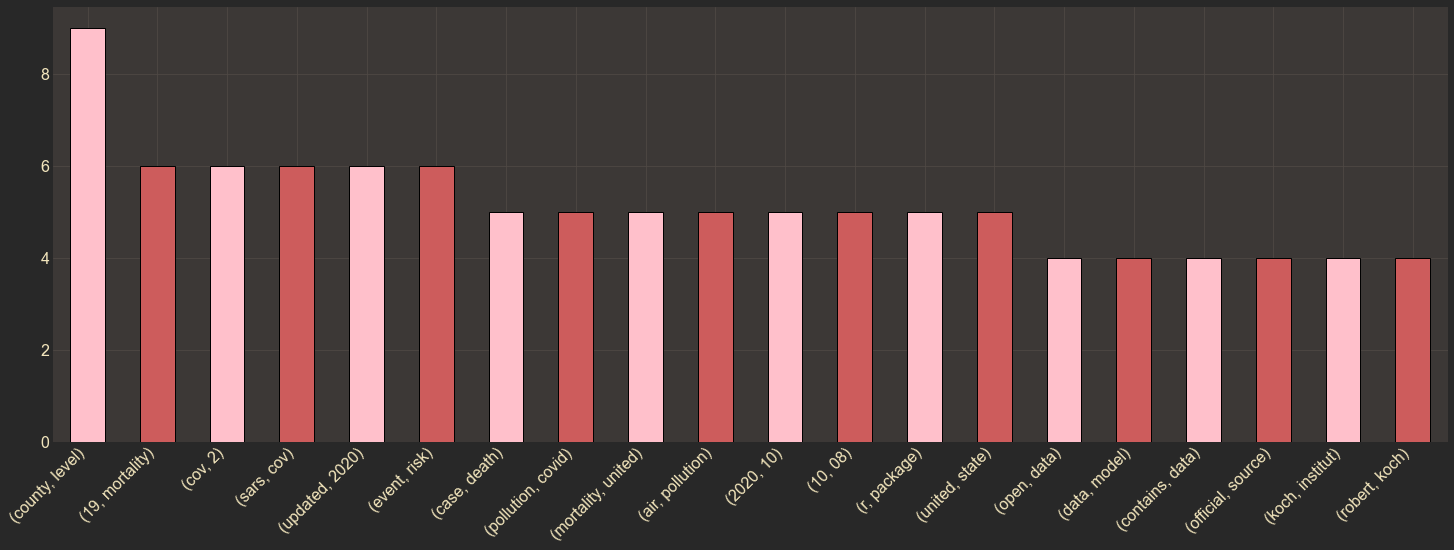

In [66]:
# find top 20 r only bigrams
r_only_bigrams = r_bigrams[r_bigrams.isin(non_r_bigrams) == False]
top_20_r_only_bigrams = r_only_bigrams.value_counts().sort_values(ascending=False).head(20)# visualize r only bigrams counts
top_20_r_only_bigrams.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

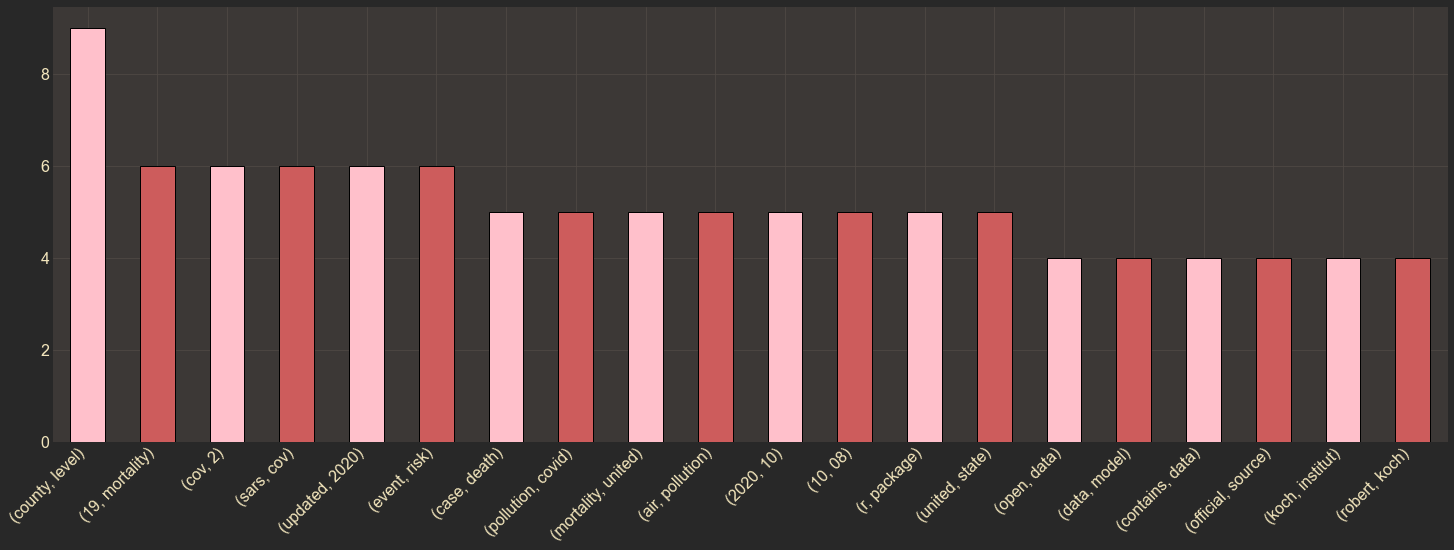

In [67]:
# visualize r only bigrams counts
top_20_r_only_bigrams.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

In [68]:
# find top 20 typescript only bigrams
ts_only_bigrams = ts_bigrams[ts_bigrams.isin(non_ts_bigrams) == False]
top_20_ts_only_bigrams = ts_only_bigrams.value_counts().sort_values(ascending=False).head(20)

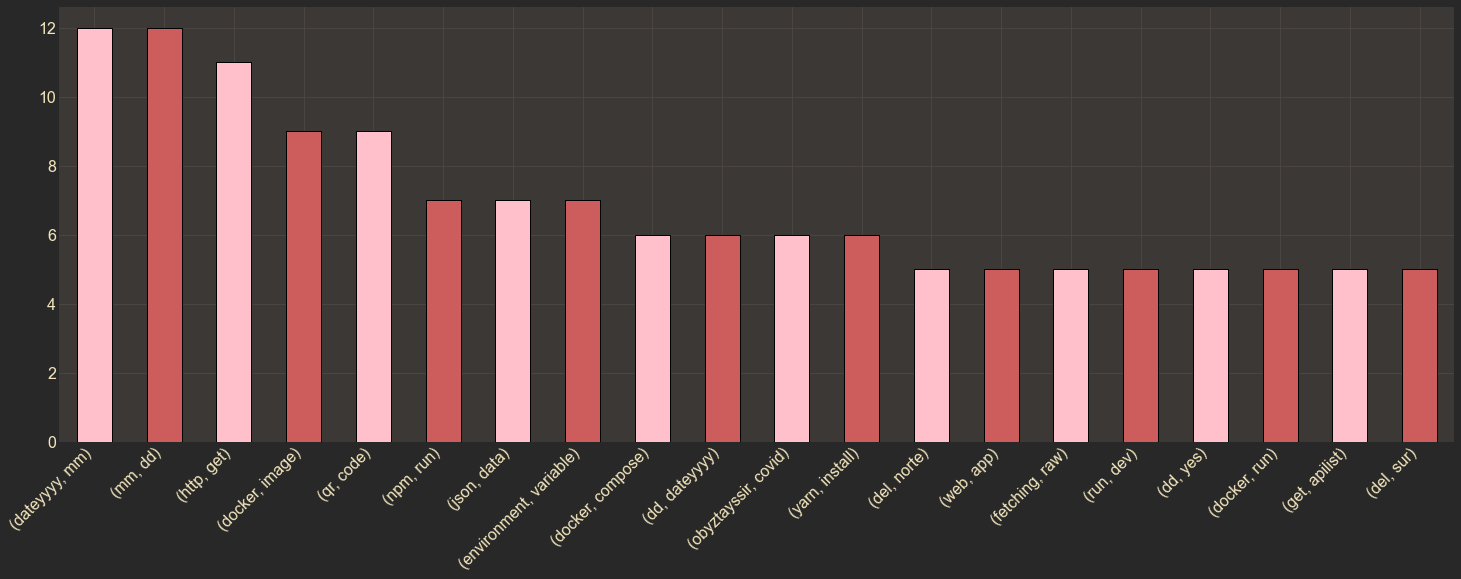

In [69]:
# visualize typescript only bigrams counts
top_20_ts_only_bigrams.plot.bar(ec='k', color=['pink', 'indianred'])
plt.xticks(rotation=45, ha='right')
plt.show()

#### Takeaways

Much like individual word exploration, bigrams of readme contents were found to largely contain subject matter related to COVID-19 and the institutions and regions involved in its spread and/or research. Due to Python being the largest class, it had higher weight in determining the most frequent elements for bigram exploration, just like with individual words.

### Modeling

Using the insights obtained in exploration, several models will be created and fit to the in-sample data (`train`) to adjust hyperparameters using out-of-sample data (`validate`) to evaluate performance. The combination of algorithm, hyperparameters, and features with the best measured performance in accuracy will be used on the final data set (`test`)

In [70]:
# import NLP vectorizer tools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# import classifier algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# additional imports
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

#### Create Sparse Matrices

In [71]:
# use CountVectorizer for sparse matrix of individual lemmatized readme words


# create CV object
cv = CountVectorizer()
# fit and create transformed matrix for train
X_train_cv = cv.fit_transform(X_train.lemmatized_readme)
# create transformed matrices for validate, test
X_val_cv = cv.transform(X_validate.lemmatized_readme)
X_test_cv = cv.transform(X_test.lemmatized_readme)

In [72]:
# use CountVectorizer for sparse matrix of individual lemmatized readme bigrams


# create bigram CV object
bi_cv = CountVectorizer(ngram_range=(2, 2))
# fit and create transformed matrix for train
X_train_bi = bi_cv.fit_transform(X_train.lemmatized_readme)
# create transformed matrices for validate, test
X_val_bi = bi_cv.transform(X_validate.lemmatized_readme)
X_test_bi = bi_cv.transform(X_test.lemmatized_readme)

In [73]:
# use TfidfVectorizer for sparse matrix of individual lemmatized readme words


# create Tfidf object
tfidf = TfidfVectorizer(binary=True)
# fit and create transformed matrix for train
X_train_tfidf = tfidf.fit_transform(X_train.lemmatized_readme)
# create transformed matrices for validate, test
X_val_tfidf = tfidf.transform(X_validate.lemmatized_readme)
X_test_tfidf = tfidf.transform(X_test.lemmatized_readme)

#### Baseline Creation

Using Scikit-learn's `DummyClassifer` function, a baseline will be constructed using the most frequent class to compare model performance against. In context, the most common target class `0` for Python.

In [74]:
# create dummy classsifier object
dummy = DummyClassifier(strategy="most_frequent")
# fit dummy to train
dummy = dummy.fit(X_train, y_train.target_class)
# create baseline predictions
baseline = dummy.predict(X_train)
dummy.score(baseline, y_train.target_class)

0.4409448818897638

#### Decision Tree

In [75]:
# using DT with individual word counts


# create tree object
tree_cv = DecisionTreeClassifier(max_depth=3)
# fit tree to train data
tree_cv.fit(X_train_cv, y_train.target_class)
# output in-sample score
tree_cv.score(X_train_cv, y_train.target_class)

0.6456692913385826

In [76]:
# output out-of-sample score
tree_cv.score(X_val_cv, y_validate.target_class)

0.5348837209302325

In [77]:
# using DT with bigrams


# create tree object
tree_bi = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2)
# fit tree to train data
tree_bi.fit(X_train_bi, y_train.target_class)
# output in-sample score
tree_bi.score(X_train_bi, y_train.target_class)

0.7559055118110236

In [78]:
# output out-of-sample score
tree_bi.score(X_val_bi, y_validate.target_class)

0.5116279069767442

In [79]:
# using DT with tfidf


# create tree object
tree_tfidf = DecisionTreeClassifier(max_depth=3, random_state=19)
# fit tree to train data
tree_tfidf.fit(X_train_tfidf, y_train.target_class)
# output in-sample score
tree_tfidf.score(X_train_tfidf, y_train.target_class)

0.6614173228346457

In [80]:
# output out-of-sample score
tree_tfidf.score(X_val_tfidf, y_validate.target_class)

0.5813953488372093

##### Tree Feature Importances

In [81]:
pd.Series(dict(zip(cv.get_feature_names(), tree_cv.feature_importances_))).sort_values().tail(10)

display           0.000000
displaydisplay    0.000000
displayed         0.000000
disease           0.000000
hospital          0.104047
suggestion        0.104081
monorepo          0.118911
support           0.140186
python            0.166416
npm               0.366359
dtype: float64

In [82]:
pd.Series(dict(zip(bi_cv.get_feature_names(), tree_bi.feature_importances_))).sort_values().tail(10)

easy use              0.047845
local machine         0.049007
case count            0.049044
start run             0.052217
training process      0.056333
data daily            0.061437
contribute project    0.062637
19 data               0.063925
pip install           0.092073
npm install           0.152603
dtype: float64

In [83]:
pd.Series(dict(zip(tfidf.get_feature_names(), tree_tfidf.feature_importances_))).sort_values().tail(10)

display           0.000000
displaydisplay    0.000000
displayed         0.000000
diseasemodel      0.000000
hospital          0.100698
monorepo          0.115083
score             0.124356
support           0.134304
python            0.170993
npm               0.354566
dtype: float64

**Notes**

With the decision tree models, all three `train` inputs made substantial use of the "npm" in predictions, being the most important feature in all three models. Bigrams had the widest spread of feature importance, with `cv` and `tfidf` making measurable use of fewer than ten features. Thus far, the best performing model on out-of-sample data is the bigram input with $58\%$ accuracy.

#### Random Forest

In [84]:
# using RF with individual word counts


# create forest object
forest_cv = RandomForestClassifier(n_estimators=500,
                                   max_depth=15,
                                   class_weight='balanced',
                                   bootstrap=False,
                                   random_state=19)
# fit forest to train data
forest_cv.fit(X_train_cv, y_train.target_class)
# output in-sample score
forest_cv.score(X_train_cv, y_train.target_class)

1.0

In [85]:
# output out-of-sample score
forest_cv.score(X_val_cv, y_validate.target_class)

0.5348837209302325

In [86]:
# using RF with individual word counts


# create forest object
forest_bi = RandomForestClassifier(n_estimators=500,
                                   max_depth=6,
                                   class_weight='balanced',
                                   bootstrap=False,
                                   random_state=19)
# fit forest to train data
forest_bi.fit(X_train_bi, y_train.target_class)
# output in-sample score
forest_bi.score(X_train_bi, y_train.target_class)

0.9448818897637795

In [87]:
# output out-of-sample score
forest_bi.score(X_val_bi, y_validate.target_class)

0.5348837209302325

In [88]:
# using RF with individual word counts


# create forest object
forest_tfidf = RandomForestClassifier(n_estimators=300,
                                      criterion='entropy',
                                      max_depth=10,
                                      class_weight='balanced',
                                      max_leaf_nodes=12,
                                      bootstrap=False,
                                      random_state=19)
# fit forest to train data
forest_tfidf.fit(X_train_tfidf, y_train.target_class)
# output in-sample score
forest_tfidf.score(X_train_tfidf, y_train.target_class)

0.9448818897637795

In [89]:
# output out-of-sample score
forest_tfidf.score(X_val_tfidf, y_validate.target_class)

0.5348837209302325

**Notes**

Using the `DecisionTreeClassifier` hyper parameters as a starting, the `RandomForestClassifer` was adjusted to slightly to increase out-of-sample performance. The end result was a resulted in overfitting to the training data in the all three cases, with substantial drops in performance from in- to out-of-sample data; however, the `forest` model using `tfdidf` input rose above the previous model sets and is now the top performer on out-of-sample data with $65\%$ accuracy on the `validate` data. Due to the overfitting, adjustments may need to be made if this model is to be used.

#### Multinomial Naive Bayes

In [90]:
# using MNB on individual word counts


# create mnb object
mnb_cv = MultinomialNB(alpha=2)
# fit classifier to trian
mnb_cv.fit(X_train_cv, y_train.target_class)
# view in-sample accuracy
mnb_cv.score(X_train_cv, y_train.target_class)

0.9212598425196851

In [91]:
# view MNB/CV on out-of-sample data
mnb_cv.score(X_val_cv, y_validate.target_class)

0.4883720930232558

In [92]:
# using MNB on bigrams


# create mnb object
mnb_bi = MultinomialNB(alpha=2)
# fit classifier to trian
mnb_bi.fit(X_train_bi, y_train.target_class)
# view in-sample accuracy
mnb_bi.score(X_train_bi, y_train.target_class)

1.0

In [93]:
# view MNB/CV on out-of-sample data
mnb_bi.score(X_val_bi, y_validate.target_class)

0.4418604651162791

In [94]:
# using MNB on tfidf


# create mnb object
mnb_tfidf = MultinomialNB(alpha=0)
# fit classifier to trian
mnb_tfidf.fit(X_train_tfidf, y_train.target_class)
# view in-sample accuracy
mnb_tfidf.score(X_train_tfidf, y_train.target_class)

1.0

In [95]:
# view MNB/CV on out-of-sample data
mnb_tfidf.score(X_val_tfidf, y_validate.target_class)

0.4418604651162791

**Notes**

Due to the multi-target-class nature of the question, it was though using a Naive-Bayes model should be in consideration, and three models were created for each of the sparse matrices. None of these out performed the thus far best performing model, and all were substantially over fit.

#### Modeling Takeaways

Of the 9 models, created, after tweaking hyperparameters to improve performance on out-of-sample data without over fitting, the best resulting model was the DecisionTreeClassifier making use of the TF-IDF matrix of `lemmatized_readme`. Despite a relatively lower accuracy score on the training data set, it had the lowest drop in accuracy from in- to out-of-sample data, with a score of $58\%$ accuracy on `validate`. This is the best candidate for final testing, as its performance is still higher than baseline predictions of $44\%$, and has the highest likelihood of consistent performance on the final out-of-sample test.

#### Final Test

In [96]:
# Final test using DT and TFIDF

# output final model score on test data
print(f'Final Test Accuracy: {tree_tfidf.score(X_test_tfidf, y_test.target_class):0.2%}\n')
preds = tree_tfidf.predict(X_test_tfidf)
pd.DataFrame(classification_report(y_test.target_class, preds, output_dict=True)).T

Final Test Accuracy: 58.14%



precision    recall  f1-score    support
0              0.586207  0.894737  0.708333  19.000000
1              0.583333  0.777778  0.666667   9.000000
2              1.000000  0.142857  0.250000   7.000000
3              0.000000  0.000000  0.000000   3.000000
4              0.000000  0.000000  0.000000   3.000000
5              0.000000  0.000000  0.000000   2.000000
accuracy       0.581395  0.581395  0.581395   0.581395
macro avg      0.361590  0.302562  0.270833  43.000000
weighted avg   0.543905  0.581395  0.493217  43.000000

In [97]:
score_df = pd.DataFrame({'Model': ['Random Forest-cv', 'Random Forest-bi', 'Random Forest-tdidf', 'Naive Bayes-cv', 'Naive Bayes-bi', 'Naive Bayes-tdidf'],
                        'Train': [1, 0.94, 0.94, 0.92, 1, 1],
                        'Validate': [0.53, 0.53, 0.53, 0.49, 0.44, 0.44],
                        'Test': [0, 0, 0.58, 0, 0, 0]})
score_df

Model  Train  Validate  Test
0     Random Forest-cv   1.00      0.53  0.00
1     Random Forest-bi   0.94      0.53  0.00
2  Random Forest-tdidf   0.94      0.53  0.58
3       Naive Bayes-cv   0.92      0.49  0.00
4       Naive Bayes-bi   1.00      0.44  0.00
5    Naive Bayes-tdidf   1.00      0.44  0.00

In [98]:
colors = ['#D4F1F4', '#75E6DA', '#189AB4', '#05445E', '#21B6A8', '#B1D4E0']

In [99]:
import matplotlib as mpl

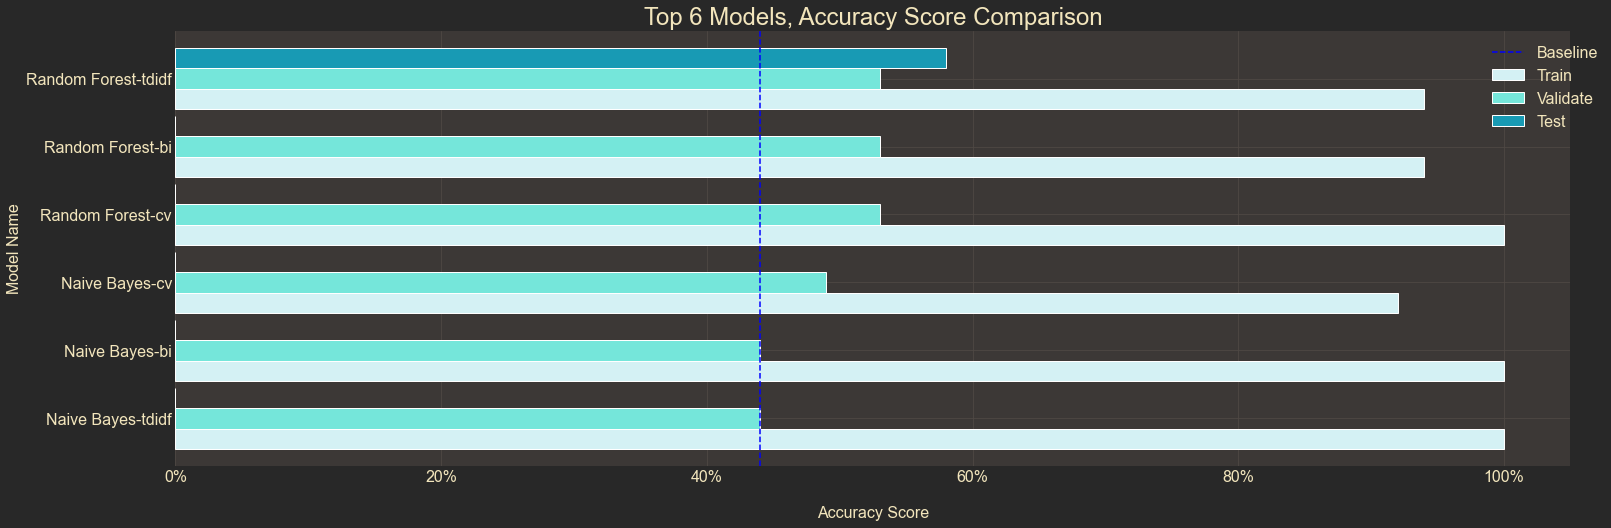

In [100]:
score_df2 = score_df.set_index('Model').sort_values(by=['Validate', 'Model'], ascending=False)
score_df2.sort_values(by=['Test', 'Validate']).plot.barh(alpha=1, width=0.9, ec='white', color=colors)
# plot baseline
plt.axvline(x=.44, c='blue', linestyle='--')
plt.legend(['Baseline', 'Train', 'Validate', 'Test'], bbox_to_anchor=(1.03, 1))
plt.ylabel('Model Name')
plt.xlabel('\nAccuracy Score')
# set ticks to percentages
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter('{:.0%}'.format))
plt.title('Top 6 Models, Accuracy Score Comparison', fontsize=24)
plt.show()

### Conclusion

The final results of modeling evaluation led to the use of a `DecisionTreeClassifier` using a TF-IDF matrix created using the `lemmatized_readme` column created from the original README content. Using a shallow tree model, with `max_depth=3` to prevent overfitting, the model maintained consistent performance through training, evaluation, and testing that performed well above the baseline majority class prediction.

- Baseline Accuracy: $\approx44.1\%$
- DecisionTree Accuracy: $\approx58.1\%$
    - `max_depth=3`
    - TF-IDF matrix of `lemmatized_readme`
    - Identical accuracy on evaluation and test
    - Most important single word features:
        - cd
        - join
        - 12
        - choose
        - python
        - support
        - npm

**Essential Takeaways**

Due to the class imbalance of the target, the classifier performed substantially better when predicting the top two languages of _Python_ and _JavaScript_. Reviewing the precision of each target class, Python and JavaScript both sat at $\approx58\%$, while _Jupyter_ and the remaining resulted in absolute extremes. As Jupyter is an environment for use with both _Python_ and _R_ languages, these overlapping elements may be cause for misinterpretations of the classifier. In that same vein, TypeScript is a superset of the JavaScript language, and it is possible this was also conflated by using the natural language in predicting related constructed languages.

**Future Action**

The next desirable steps in furthering the goals in this project are to better discern between language and environment. Due to the mechanism of how GitHub determines repository language, this might include obtaining the secondary language of a repository. For example, many data science projects make heavy use of Python contained within a Jupyter Notebook, and the effective language used Python. Despite this, GitHub will consider this a Jupyter Notebook language due to the volume of code contained by notebooks. By obtaining a secondary language, it is possible to better assign this environment category as either Julia, Python, or R depending on the repository.